In [1]:
# Import packages

import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import io

auth = ('FDS_DEMO_EUR_464603_SERVICES', '6hc85SGcgWCrkbJo')

In [2]:
## Define the names of factors that you are interested and enter their corresponding screening formulas

qfl_data = pd.read_excel('QFL.xlsx', header = 1)

qfl_data = qfl_data.drop(['Unnamed: 0'], axis = 1)

qfl_data.head()

,Factor Group,Field ID,Field Name,FactSet Screening Formula,Data Source,Unnamed: 6,Currency,Shares,CACCESS,Search Keywords,Data Type,String Length
0,Asset Data,DAYS_SINCE_RPT,Days Since Report,QFL_DAYS_SINCE_RPT(0),FactSet Estimates,"'Days Since Report': 'QFL_DAYS_SINCE_RPT(0)',",None,0,00QFL,"asset,data,estimates",INTEGER,NaN
1,Asset Data,DAYS_TO_RPT,Days to Report,QFL_DAYS_TO_RPT(0),FactSet Estimates,"'Days to Report': 'QFL_DAYS_TO_RPT(0)',",None,0,00QFL,"asset,data,estimates",INTEGER,NaN
2,Asset Data,ADR_FLAG,ADR Flag,QFL_ADR_FLAG(0),FactSet Reference Data,"'ADR Flag': 'QFL_ADR_FLAG(0)',",None,0,00QFL,"asset,reference,data",INTEGER,NaN
3,Asset Data,BANKRUPTCY,Bankruptcy Flag,QFL_BANKRUPTCY(0),FactSet Reference Data,"'Bankruptcy Flag': 'QFL_BANKRUPTCY(0)',",None,0,00QFL,"asset,reference,data",INTEGER,NaN
4,Asset Data,PRIMARY_LIST,Primary Listing,QFL_PRIMARY_LIST(0),FactSet Reference Data,"'Primary Listing': 'QFL_PRIMARY_LIST(0)',",None,0,00QFL,"asset,reference,data",INTEGER,NaN


In [3]:
# create QFL factor categories dictionary: Key = Field Name, Values = FactSet Screening Formula

qfl_categories = qfl_data['Factor Group'].unique()
qfl_categories = list(np.delete(qfl_categories, [0,1,2]))

for i in qfl_categories:
    globals()['qfl_{0}'.format(i).lower()] = dict(qfl_data[qfl_data['Factor Group'] == i][['FactSet Screening Formula', 'FactSet Screening Formula']].values)

qfl_categories

['Size',
 'Value',
 'Growth',
 'Profitability',
 'Efficiency',
 'Solvency',
 'Management',
 'Quality',
 'Analyst Sentiment',
 'Crowding',
 'Insider Activity',
 'Corporate Governance',
 'Momentum',
 'Volatility',
 'Market Sensitivity',
 'Technical',
 'Liquidity']

In [4]:
qfl_factors = globals()['qfl_{0}'.format('Technical').lower()] # change QFL Category here!

formulas = list(qfl_factors.values())
columns = list(qfl_factors.keys())

In [5]:
# Define Universe & QFL parameters

endpoint = "https://datadirect.factset.com/services/FastFetch?"
factlet = "ExtractBenchmarkDetail"

ids = "890100"
date = "11/30/2020"
fwd_date = "12/31/2020"

# Forward Returns, Size Class, Security Market Value (USD)

params = ['P_TOTAL_RETURN(' + str(date) + ',' + str(fwd_date) + ')',
          'QFL_SIZE_CLASS(' + str(date) + ')',
          'QFL_MKT_VAL_SEC(' + str(date) + ')']

items = 'PROPER_NAME, FG_GICS_SECTOR, PROPER(FG_COUNTRY)'

items_call = items + ',' + ','.join([str(elem) for elem in params]) + ',' + ','.join([str(qfl_elem) for qfl_elem in list(qfl_factors.values())])

# cutoff = "10"
output_format = "pipe"
showTitle = "N"
showHeader = "N"
showDataType = "N"

response = requests.post(endpoint, auth=auth, data = {'factlet':factlet, 
                                                      'ids':ids, 
                                                      'items': items_call,
                                                      'dates':date, 
                                                      # 'cutoff':cutoff,
                                                      'format':output_format,
                                                      'showTitle':showTitle,
                                                      'showHeader':showHeader,
                                                      'showDataType':showDataType})

df = pd.read_csv(io.StringIO(response.text), sep = '|')

In [6]:
col_universe = ['BENCHMARK_ID', 'DATE', 'SECURITY_ID', 'Weight', 'proper_name',
       'fg_gics_sector', 'proper', 'p_total_return', 'qfl_size_class', 'qfl_mkt_val_sec']
items_call_pipe = '|'.join([str(qfl_elem) for qfl_elem in list(qfl_factors.values())])
columns_name = col_universe + items_call_pipe.split('|')
df.columns = pd.Index(columns_name)

In [7]:
qfl_df = df

In [8]:
qfl_df.head()

,BENCHMARK_ID,DATE,SECURITY_ID,Weight,proper_name,fg_gics_sector,proper,p_total_return,qfl_size_class,qfl_mkt_val_sec,"QFL_MAVG_SPREAD(0,10D_50D)","QFL_MAVG_SPREAD(0,30D_100D)","QFL_MAVG_SPREAD(0,50D_200D)","QFL_GOLD_CROSS(0,10D_50D)","QFL_GOLD_CROSS(0,30D_100D)","QFL_GOLD_CROSS(0,50D_200D)","QFL_DEATH_CROSS(0,10D_50D)","QFL_DEATH_CROSS(0,30D_100D)","QFL_DEATH_CROSS(0,50D_200D)","QFL_ALPHA(0,21D)","QFL_ALPHA(0,63D)","QFL_ALPHA(0,252D)","QFL_ALPHA(0,36M)","QFL_ALPHA(0,60M)","QFL_ATR(0,21D)","QFL_ATR(0,63D)","QFL_ATR(0,252D)","QFL_ATR(0,36M)","QFL_ATR(0,60M)","QFL_ULCER(0,21D)","QFL_ULCER(0,63D)","QFL_ULCER(0,252D)","QFL_ULCER(0,36M)","QFL_ULCER(0,60M)","QFL_UPI(0,21D)","QFL_UPI(0,63D)","QFL_UPI(0,252D)","QFL_UPI(0,36M)","QFL_UPI(0,60M)","QFL_DRAWDOWN(0,21D)","QFL_DRAWDOWN(0,63D)","QFL_DRAWDOWN(0,252D)","QFL_DRAWDOWN(0,36M)","QFL_DRAWDOWN(0,60M)","QFL_MFV(0,CT)","QFL_ADL(0,21D)","QFL_ADL(0,63D)","QFL_ADL(0,252D)","QFL_ADLR(0,21D)","QFL_ADLR(0,63D)","QFL_ADLR(0,252D)","QFL_OBV(0,21D)","QFL_OBV(0,63D)","QFL_OBV(0,252D)","QFL_OBVR(0,21D)","QFL_OBVR(0,63D)","QFL_OBVR(0,252D)"
0,890100,30-Nov-2020,03783310,4.204100,Apple Inc.,Information Technology,United States,11.457372,Mega Cap,2024064.4,0.908422,2.190924,22.300552,0.0,0.0,0.0,0.0,0.0,0.0,0.282931,-11.076964,60.618600,134.482420,214.451050,2.553043,3.655237,3.323008,15.338877,13.083320,2.237526,12.279083,11.021425,11.348907,10.539279,4.267644,-0.752724,6.951158,3.643182,3.119152,5.361592,18.691008,31.427267,30.509155,30.509155,0.076650,0.468663,-3.214661,15.559433,-0.003685,-0.018809,0.069058,0.897733,-0.483903,10.278099,-0.027450,-0.018710,0.051649
1,890100,30-Nov-2020,59491810,3.141281,Microsoft Corporation,Information Technology,United States,3.900588,Mega Cap,1618475.4,0.193012,0.673807,9.430277,0.0,0.0,0.0,0.0,0.0,0.0,-7.456026,-8.933098,24.984148,128.761020,244.851440,2.456762,2.893712,3.010765,11.462117,9.987785,3.763058,9.068143,8.465732,4.158308,3.934258,1.595996,-0.810231,4.850116,9.066426,8.287066,5.834345,13.494499,28.039879,11.859373,11.859373,0.283574,0.228491,-0.827233,6.424770,-0.019273,-0.004223,0.029779,0.310049,-0.075904,9.723318,0.000387,0.047202,0.042911
2,890100,30-Nov-2020,02313510,2.735749,"Amazon.com, Inc.",Consumer Discretionary,United States,2.805829,Mega Cap,1589567.8,-1.113510,-0.660509,15.358949,0.0,0.0,0.0,0.0,0.0,0.0,-6.164508,-11.868568,70.193710,128.254990,289.742830,2.798251,3.468011,3.092639,14.415512,12.789499,5.131093,10.652411,7.384572,9.556258,8.590690,0.846603,-0.966041,10.829136,4.092957,4.266623,8.638771,16.325867,22.744700,26.209682,26.209682,-0.140661,0.175216,-2.166270,11.483603,-0.033030,-0.011937,0.068943,0.115145,-5.485584,26.190533,0.020988,-0.004588,0.126230
3,890100,30-Nov-2020,30303M10,1.356526,"Facebook, Inc. Class A",Communication Services,United States,-1.375598,Mega Cap,665827.3,1.323950,3.795648,15.742278,0.0,0.0,0.0,0.0,0.0,0.0,-10.125097,-9.971259,26.578670,8.150616,78.190346,3.025216,3.436019,3.509291,15.387778,13.052379,5.906473,11.249933,12.083881,11.856417,9.451471,0.891863,-0.750198,3.374127,1.354318,2.283761,8.907962,17.966940,34.592120,31.453276,31.453276,0.542860,2.111987,-1.672756,17.121756,0.076933,-0.021562,0.069752,-2.098329,-7.116575,29.107930,-0.127555,-0.010739,0.157323
4,890100,30-Nov-2020,02079K10,1.085045,Alphabet Inc. Class C,Communication Services,United States,-0.503194,Mega Cap,580810.4,8.886969,7.639766,11.351240,0.0,0.0,0.0,0.0,0.0,0.0,-4.438792,0.437721,16.877655,32.805202,58.541954,2.235345,2.935353,2.871144,12.355530,10.828825,1.065535,10.009716,11.015576,8.063087,6.829960,8.089769,0.187634,2.759648,2.468466,2.759453,2.611455,18.114530,30.790134,21.226238,21.226238,-0.360936,-1.380326,-3.656611,6.309656,-0.069573,-0.032374,0.039133,2.033520,3.476768,15.274876,0.010897,0.158420,0.065758


In [9]:
qfl_df.tail()

,BENCHMARK_ID,DATE,SECURITY_ID,Weight,proper_name,fg_gics_sector,proper,p_total_return,qfl_size_class,qfl_mkt_val_sec,"QFL_MAVG_SPREAD(0,10D_50D)","QFL_MAVG_SPREAD(0,30D_100D)","QFL_MAVG_SPREAD(0,50D_200D)","QFL_GOLD_CROSS(0,10D_50D)","QFL_GOLD_CROSS(0,30D_100D)","QFL_GOLD_CROSS(0,50D_200D)","QFL_DEATH_CROSS(0,10D_50D)","QFL_DEATH_CROSS(0,30D_100D)","QFL_DEATH_CROSS(0,50D_200D)","QFL_ALPHA(0,21D)","QFL_ALPHA(0,63D)","QFL_ALPHA(0,252D)","QFL_ALPHA(0,36M)","QFL_ALPHA(0,60M)","QFL_ATR(0,21D)","QFL_ATR(0,63D)","QFL_ATR(0,252D)","QFL_ATR(0,36M)","QFL_ATR(0,60M)","QFL_ULCER(0,21D)","QFL_ULCER(0,63D)","QFL_ULCER(0,252D)","QFL_ULCER(0,36M)","QFL_ULCER(0,60M)","QFL_UPI(0,21D)","QFL_UPI(0,63D)","QFL_UPI(0,252D)","QFL_UPI(0,36M)","QFL_UPI(0,60M)","QFL_DRAWDOWN(0,21D)","QFL_DRAWDOWN(0,63D)","QFL_DRAWDOWN(0,252D)","QFL_DRAWDOWN(0,36M)","QFL_DRAWDOWN(0,60M)","QFL_MFV(0,CT)","QFL_ADL(0,21D)","QFL_ADL(0,63D)","QFL_ADL(0,252D)","QFL_ADLR(0,21D)","QFL_ADLR(0,63D)","QFL_ADLR(0,252D)","QFL_OBV(0,21D)","QFL_OBV(0,63D)","QFL_OBV(0,252D)","QFL_OBVR(0,21D)","QFL_OBVR(0,63D)","QFL_OBVR(0,252D)"
1595,890100,30-Nov-2020,BZ22BK,0.002738,SmartCentres Real Estate Investment Trust,Real Estate,Canada,-3.552645,Mid Cap,2688.3582,11.678183,7.621849,2.444029,0.0,0.0,0.0,0.0,0.0,0.0,-4.092777,13.512959,-17.561626,-7.142017,-28.724890,3.080836,2.678412,3.457966,9.561550,8.378826,1.636300,3.780040,28.745325,18.073332,17.063430,9.240067,4.372513,-0.556519,0.024382,0.031647,3.143633,8.673707,53.033535,43.653347,43.653347,1.520799,2.229793,0.473948,-0.928018,0.033417,-0.005363,-0.014788,-2.157947,-3.800763,-6.386661,0.029716,0.015417,-0.019087
1596,890100,30-Nov-2020,B2NT8S,0.002637,"Seven Bank, Ltd.",Financials,Japan,-4.803491,Mid Cap,2619.2988,-5.886621,-6.623697,-9.362716,0.0,0.0,0.0,0.0,0.0,0.0,-11.464783,-20.298260,-34.205807,-29.312151,-58.214480,2.277499,1.998885,2.535431,10.772435,11.594720,6.408980,6.533640,21.386190,19.243034,32.920414,-0.709232,-1.798955,-1.470330,-0.558665,-0.379892,9.842514,12.927738,34.171047,36.332546,50.478436,0.398857,-1.640006,-5.091897,-8.518397,-0.072990,-0.077047,-0.030194,-0.382792,-1.837806,-11.114891,-0.090975,-0.022479,-0.044421
1597,890100,30-Nov-2020,BKSLS5,0.002617,First Capital Real Estate Investment Trust,Real Estate,Canada,-12.513375,Mid Cap,2634.8494,14.846718,1.573670,-4.097897,0.0,0.0,0.0,0.0,0.0,0.0,4.515553,13.495806,-22.093964,-22.648426,-32.149387,3.949008,3.023010,3.561333,10.405935,8.585430,1.648953,8.229765,31.165792,18.378870,15.137127,19.607721,2.130725,-0.671685,-0.261487,0.018778,3.268232,17.642021,48.584476,43.519936,43.519936,2.547487,4.442949,4.892361,6.238459,0.114595,0.030739,0.004141,0.306530,2.383176,5.529695,0.155204,0.064139,0.026883
1598,890100,30-Nov-2020,659844,0.002463,Mitsubishi Motors Corporation,Consumer Discretionary,Japan,15.425528,Mid Cap,2808.4746,-7.412624,-13.421404,-20.899206,0.0,0.0,0.0,0.0,0.0,0.0,-16.923790,-41.343758,-65.338950,-70.968360,-92.314980,4.578872,3.805577,3.876962,15.429597,16.341328,4.788034,19.104370,41.006886,44.089146,46.368748,-0.620358,-1.226814,-1.428111,-0.756360,-0.541250,8.737865,29.323301,61.237120,77.609420,81.068270,-0.218460,1.141804,-2.512894,-15.565551,0.116686,-0.066100,-0.072812,1.733296,-4.241222,-15.470636,0.127520,-0.099050,-0.066563
1599,890100,30-Nov-2020,656950,0.002419,Maruichi Steel Tube Ltd.,Materials,Japan,4.007292,Small Cap,2063.3816,-7.336569,-7.908732,-3.382671,0.0,0.0,0.0,0.0,0.0,0.0,-16.640457,-28.905950,-28.395058,-16.988780,-29.204662,3.205702,2.733735,3.014050,12.249365,11.477697,5.425308,13.343111,16.043644,19.354034,16.521679,-1.284391,-1.388851,-1.491325,-0.303810,-0.274191,12.159997,24.925766,31.601881,38.513687,38.513687,-0.318080,-3.402959,-2.887371,-4.570753,-0.133354,-0.023211,-0.005274,-0.096915,-1.803298,-7.699362,-0.043992,-0.048263,-0.032402


In [10]:
# Summary Stats

qfl_df.describe()

,BENCHMARK_ID,Weight,p_total_return,qfl_mkt_val_sec,"QFL_MAVG_SPREAD(0,10D_50D)","QFL_MAVG_SPREAD(0,30D_100D)","QFL_MAVG_SPREAD(0,50D_200D)","QFL_GOLD_CROSS(0,10D_50D)","QFL_GOLD_CROSS(0,30D_100D)","QFL_GOLD_CROSS(0,50D_200D)","QFL_DEATH_CROSS(0,10D_50D)","QFL_DEATH_CROSS(0,30D_100D)","QFL_DEATH_CROSS(0,50D_200D)","QFL_ALPHA(0,21D)","QFL_ALPHA(0,63D)","QFL_ALPHA(0,252D)","QFL_ALPHA(0,36M)","QFL_ALPHA(0,60M)","QFL_ATR(0,21D)","QFL_ATR(0,63D)","QFL_ATR(0,252D)","QFL_ATR(0,36M)","QFL_ATR(0,60M)","QFL_ULCER(0,21D)","QFL_ULCER(0,63D)","QFL_ULCER(0,252D)","QFL_ULCER(0,36M)","QFL_ULCER(0,60M)","QFL_UPI(0,21D)","QFL_UPI(0,63D)","QFL_UPI(0,252D)","QFL_UPI(0,36M)","QFL_UPI(0,60M)","QFL_DRAWDOWN(0,21D)","QFL_DRAWDOWN(0,63D)","QFL_DRAWDOWN(0,252D)","QFL_DRAWDOWN(0,36M)","QFL_DRAWDOWN(0,60M)","QFL_MFV(0,CT)","QFL_ADL(0,21D)","QFL_ADL(0,63D)","QFL_ADL(0,252D)","QFL_ADLR(0,21D)","QFL_ADLR(0,63D)","QFL_ADLR(0,252D)","QFL_OBV(0,21D)","QFL_OBV(0,63D)","QFL_OBV(0,252D)","QFL_OBVR(0,21D)","QFL_OBVR(0,63D)","QFL_OBVR(0,252D)"
count,1600.0,1600.000000,1597.000000,1.598000e+03,1597.000000,1596.000000,1592.000000,1597.000000,1596.000000,1592.000000,1597.000000,1596.000000,1592.000000,1598.000000,1596.000000,1592.000000,1551.000000,1517.000000,1598.000000,1596.000000,1592.000000,1551.000000,1517.000000,1598.000000,1596.000000,1592.000000,1551.000000,1517.000000,1598.000000,1596.000000,1592.000000,1551.000000,1517.000000,1598.000000,1596.000000,1592.000000,1551.000000,1517.000000,1598.000000,1598.000000,1596.000000,1592.000000,1598.000000,1596.000000,1592.000000,1598.000000,1598.000000,1598.000000,1598.000000,1596.000000,1592.000000
mean,890100.0,0.062500,3.118575,3.489420e+04,6.440706,2.998166,7.013248,0.006888,0.010652,0.010050,0.011271,0.001253,0.000628,1.939875,3.379792,4.402095,22.046381,56.952713,3.347615,3.002761,3.540645,13.798191,12.665780,2.959584,6.362220,19.397786,17.858925,16.585422,9.326964,2.492775,1.352102,1.141690,1.149495,6.327866,13.368780,41.351179,36.966059,38.728499,-0.033166,0.731489,-0.472471,1.042812,0.038131,-0.007764,0.003281,2.351780,1.577499,4.014814,0.109649,0.035114,0.013806
std,0.0,0.177252,7.256757,9.150908e+04,7.766661,6.314606,11.188237,0.082733,0.102688,0.099777,0.105599,0.035389,0.025063,10.802944,14.412818,47.654206,115.770182,242.837231,1.140891,0.917323,0.963953,3.881674,3.566782,2.458159,3.359055,9.914580,10.174337,9.281708,10.960630,3.958958,3.735321,2.213802,1.646679,3.825104,5.590107,12.621928,15.368675,15.595219,1.123778,2.998590,4.391707,14.325384,0.142399,0.068964,0.060337,4.610118,7.278738,23.733028,0.244094,0.122376,0.097586
min,890100.0,0.002419,-31.602722,2.063382e+03,-14.490694,-18.568790,-28.185493,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-60.916410,-41.343758,-84.270065,-169.323960,-257.856800,0.166304,0.289287,0.687039,5.278983,5.766660,0.031053,0.672143,2.609790,2.383206,3.109541,-2.397475,-1.873262,-1.491325,-0.772799,-0.541250,0.091269,0.924238,7.606688,5.562583,9.397998,-16.876888,-14.557998,-33.791275,-118.339310,-0.504694,-0.575029,-0.524536,-11.433582,-24.168556,-47.572500,-0.655809,-0.301538,-0.245823
25%,890100.0,0.012927,-1.169592,8.494103e+03,1.017439,-1.192881,-0.123553,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.407725,-5.995095,-18.238627,-24.605198,-28.525173,2.610698,2.404262,2.892025,11.131558,10.231287,1.423054,3.990866,11.633364,9.682759,9.433134,1.817807,-0.059992,-0.530370,-0.173262,0.055619,3.679282,9.446322,32.135876,25.116582,26.460974,-0.218331,-0.425822,-2.120245,-3.513689,-0.024309,-0.032224,-0.016777,0.306647,-0.933850,-3.446510,0.005228,-0.009741,-0.018787
50%,890100.0,0.024960,2.384615,1.491753e+04,5.670237,2.787077,5.936420,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.270828,2.039934,-2.503111,1.983261,15.694061,3.114675,2.818666,3.356808,13.177849,12.107872,2.229995,5.576757,17.324298,15.875796,14.620126,6.191492,1.522455,0.122026,0.316763,0.547537,5.376779,12.351681,40.475713,35.220673,37.123950,0.035064,0.416494,-0.261960,0.1670

In [11]:
# Check NAs

qfl_df.isna().sum()

BENCHMARK_ID                    0
DATE                            0
SECURITY_ID                     0
Weight                          0
proper_name                     0
fg_gics_sector                  2
proper                          0
p_total_return                  3
qfl_size_class                  2
qfl_mkt_val_sec                 2
QFL_MAVG_SPREAD(0,10D_50D)      3
QFL_MAVG_SPREAD(0,30D_100D)     4
QFL_MAVG_SPREAD(0,50D_200D)     8
QFL_GOLD_CROSS(0,10D_50D)       3
QFL_GOLD_CROSS(0,30D_100D)      4
QFL_GOLD_CROSS(0,50D_200D)      8
QFL_DEATH_CROSS(0,10D_50D)      3
QFL_DEATH_CROSS(0,30D_100D)     4
QFL_DEATH_CROSS(0,50D_200D)     8
QFL_ALPHA(0,21D)                2
QFL_ALPHA(0,63D)                4
QFL_ALPHA(0,252D)               8
QFL_ALPHA(0,36M)               49
QFL_ALPHA(0,60M)               83
QFL_ATR(0,21D)                  2
QFL_ATR(0,63D)                  4
QFL_ATR(0,252D)                 8
QFL_ATR(0,36M)                 49
QFL_ATR(0,60M)                 83
QFL_ULCER(0,21

In [12]:
# Filter for float/numeric parameters only

filter_idx = [idx for idx, col in enumerate(qfl_df.columns) if idx > 9 and qfl_df[col].values.dtype == 'float64']

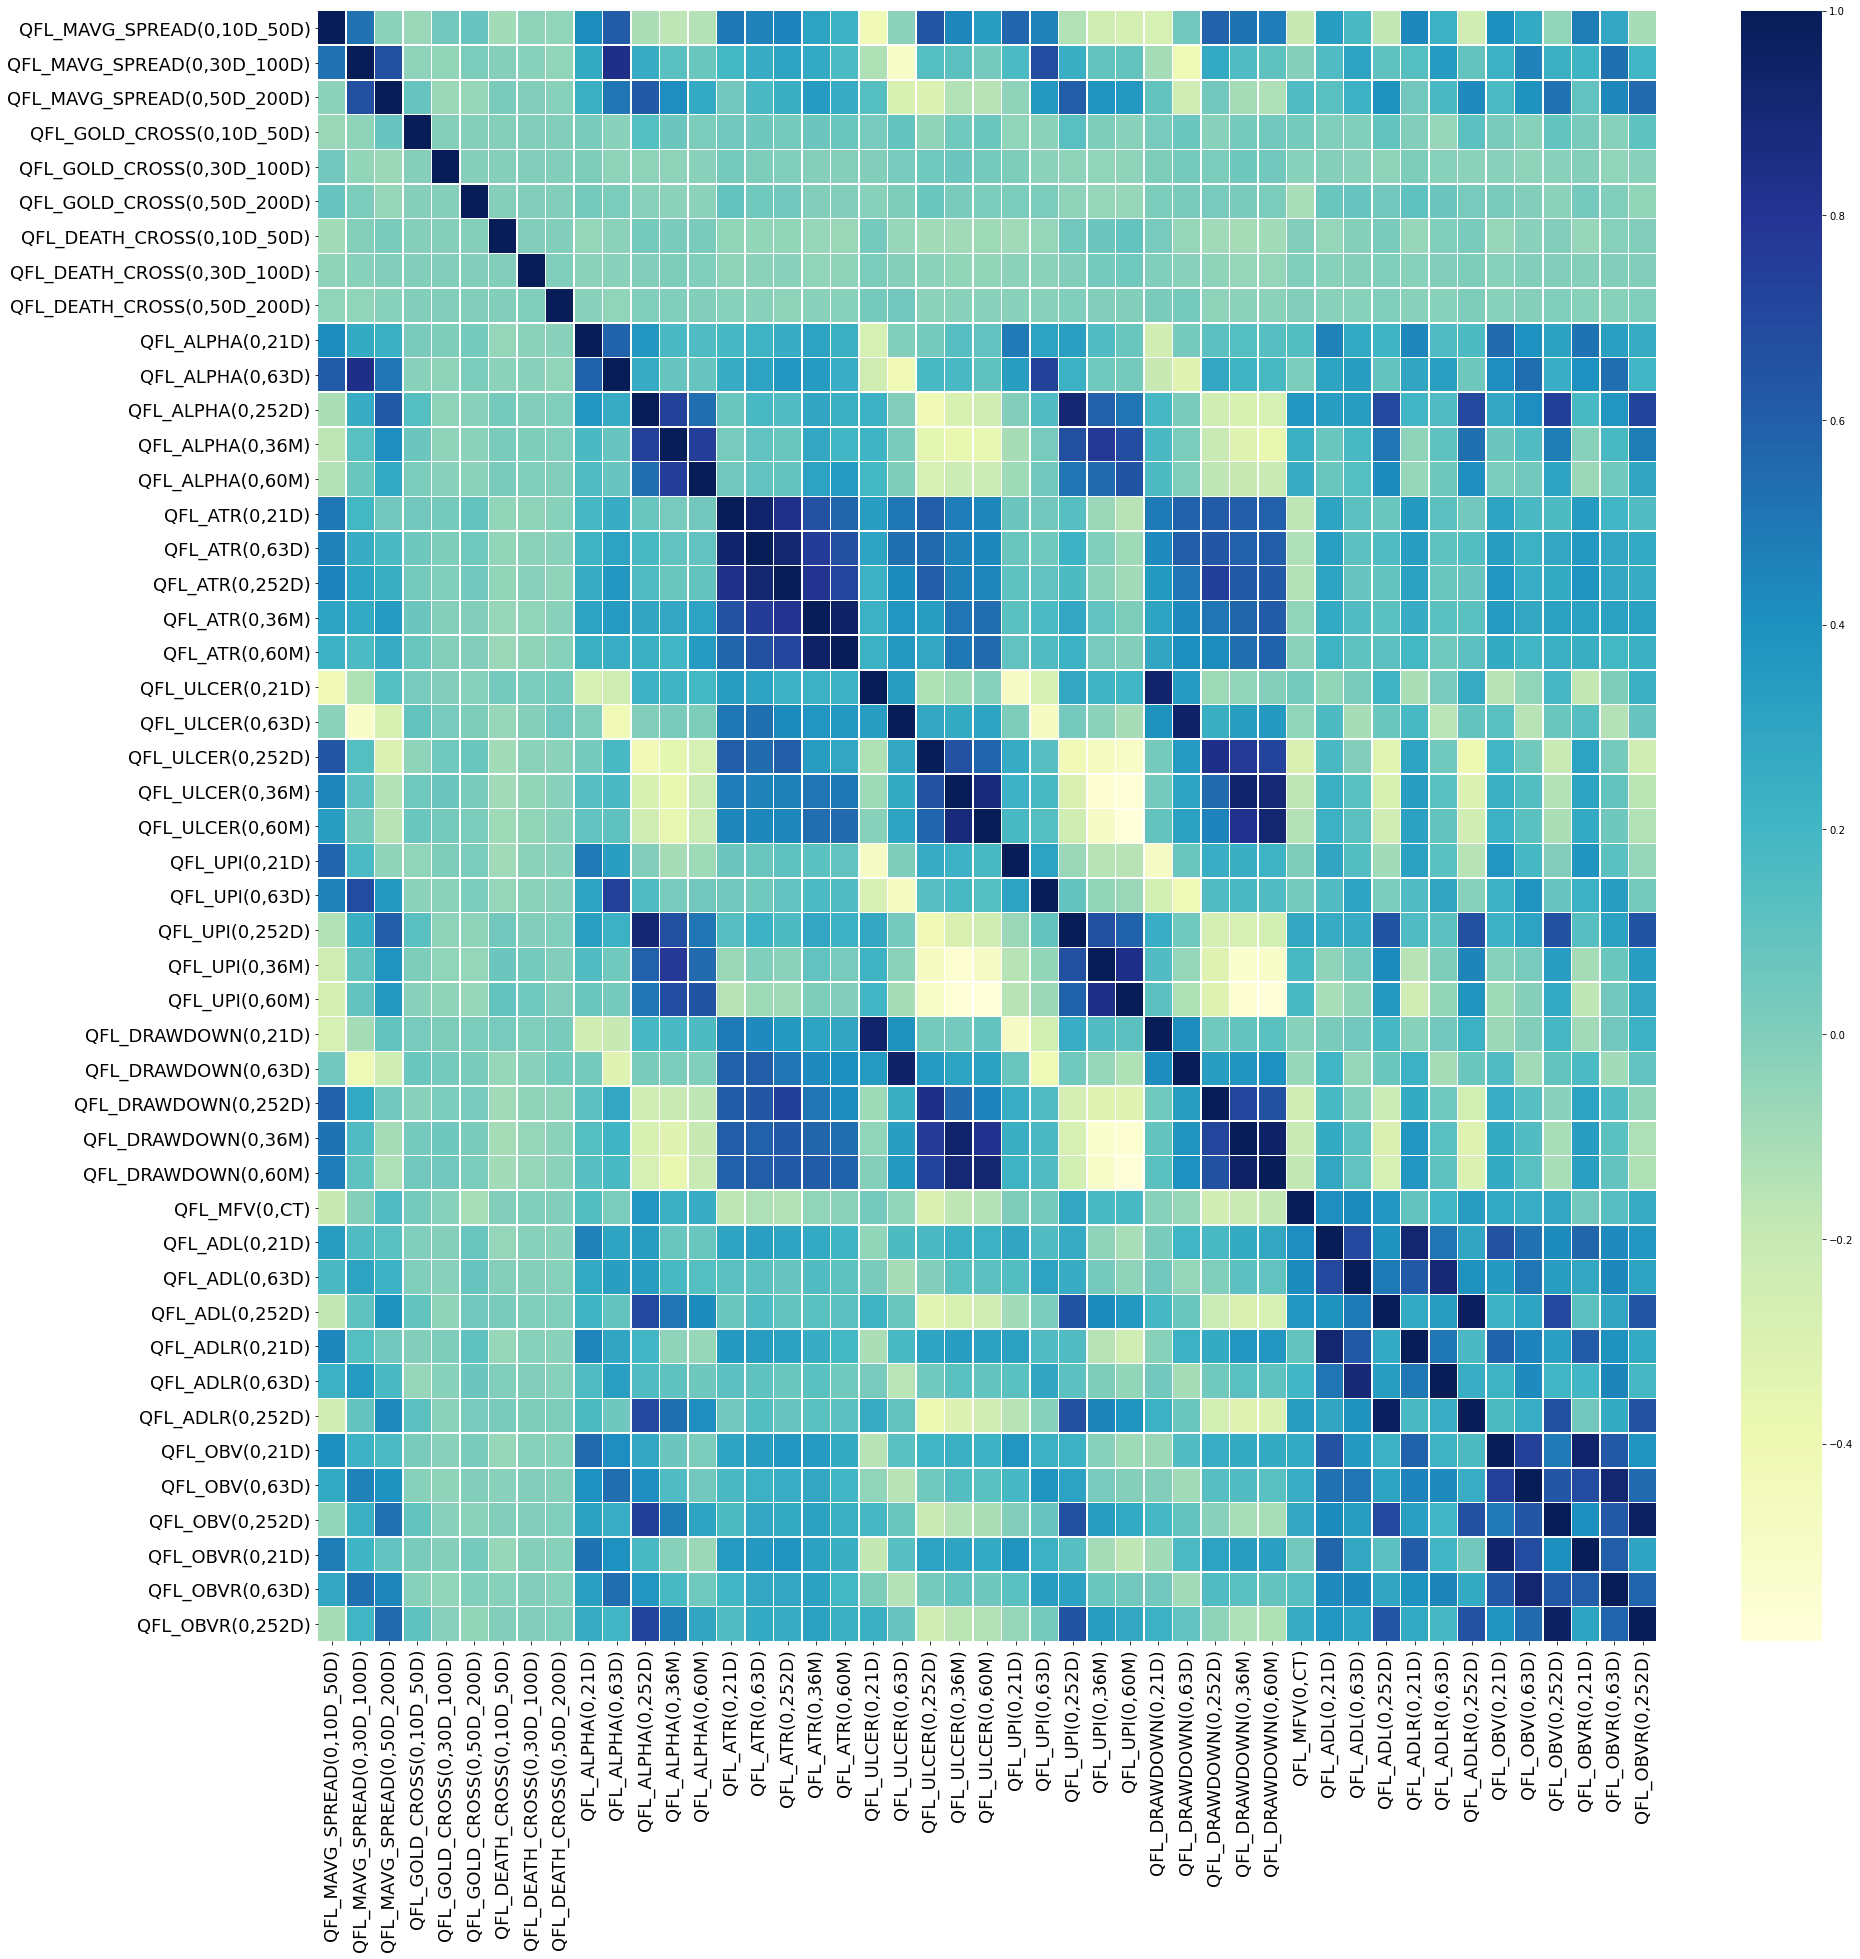

In [50]:
## Plot the correlation between each pair of factors

fig, ax = plt.subplots(figsize=(30,30))
hm = sns.heatmap(qfl_df[[c for c in qfl_df.columns[filter_idx]]].corr(), cmap="YlGnBu", annot = False, linewidths=.5, ax = ax)
hm.set_yticklabels(hm.get_ymajorticklabels(), fontsize = 18, rotation=0)
hm.set_xticklabels(hm.get_xmajorticklabels(), fontsize = 18, rotation=90)
plt.show()

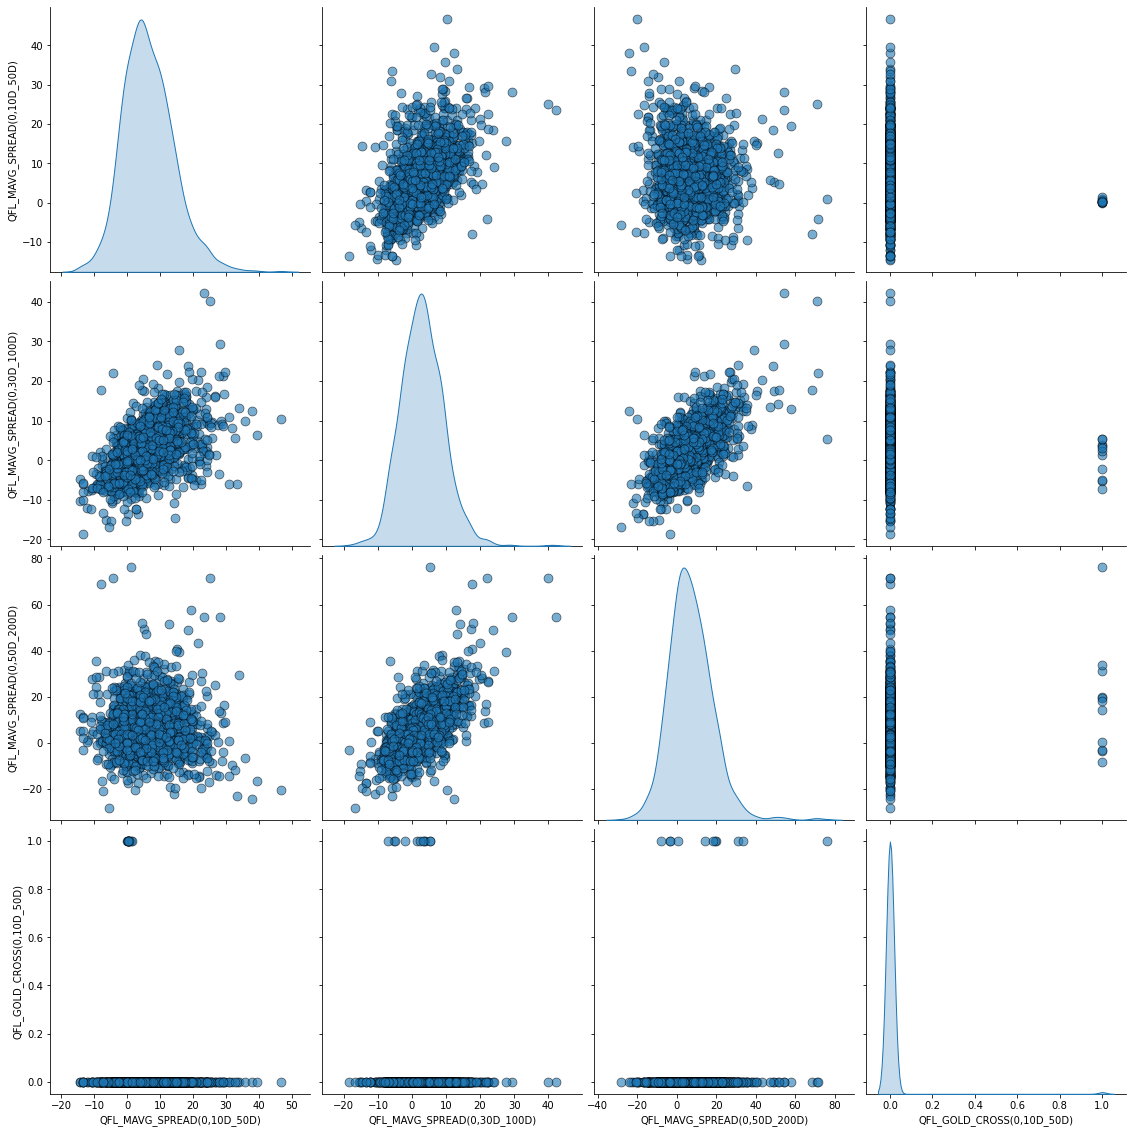

In [14]:
# Pairplot

sns.pairplot(qfl_df[qfl_df.columns[filter_idx[:4]].values], diag_kind = 'kde',
             plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'}, height = 4);
#plt.show()

In [15]:
qfl_df[qfl_df.columns[filter_idx[:4]].values]

,"QFL_MAVG_SPREAD(0,10D_50D)","QFL_MAVG_SPREAD(0,30D_100D)","QFL_MAVG_SPREAD(0,50D_200D)","QFL_GOLD_CROSS(0,10D_50D)"
0,0.908422,2.190924,22.300552,0.0
1,0.193012,0.673807,9.430277,0.0
2,-1.113510,-0.660509,15.358949,0.0
3,1.323950,3.795648,15.742278,0.0
4,8.886969,7.639766,11.351240,0.0
...,...,...,...,...
1595,11.678183,7.621849,2.444029,0.0
1596,-5.886621,-6.623697,-9.362716,0.0
1597,14.846718,1.573670,-4.097897,0.0
1598,-7.412624,-13.421404,-20.899206,0.0


In [16]:
# Other Statistics

advanced_describe = {}
stats_table = pd.DataFrame()
for factor in list(qfl_df.columns[filter_idx].values):
    advanced_describe[factor] = stats.describe(qfl_df[factor].dropna(), axis=0)    
    adv_stats = {keys: [np.round(series, 2) for series in values] for (keys, values) in zip(advanced_describe.keys(), advanced_describe.values())}
    stats_table = pd.DataFrame(adv_stats, index=['nobs', 'minmax', 'mean', 'variance', 'skewness', 'kurtosis']).T
stats_table

,nobs,minmax,mean,variance,skewness,kurtosis
"QFL_MAVG_SPREAD(0,10D_50D)",1597,"[-14.49, 46.68]",6.44,60.32,0.58,1.01
"QFL_MAVG_SPREAD(0,30D_100D)",1596,"[-18.57, 42.18]",3,39.87,0.49,1.89
"QFL_MAVG_SPREAD(0,50D_200D)",1592,"[-28.19, 76.3]",7.01,125.18,0.93,3.46
"QFL_GOLD_CROSS(0,10D_50D)",1597,"[0.0, 1.0]",0.01,0.01,11.92,140.19
"QFL_GOLD_CROSS(0,30D_100D)",1596,"[0.0, 1.0]",0.01,0.01,9.53,88.89
"QFL_GOLD_CROSS(0,50D_200D)",1592,"[0.0, 1.0]",0.01,0.01,9.82,94.51
"QFL_DEATH_CROSS(0,10D_50D)",1597,"[0.0, 1.0]",0.01,0.01,9.26,83.73
"QFL_DEATH_CROSS(0,30D_100D)",1596,"[0.0, 1.0]",0,0,28.2,793
"QFL_DEATH_CROSS(0,50D_200D)",1592,"[0.0, 1.0]",0,0,39.86,1587
"QFL_ALPHA(0,21D)",1598,"[-60.92, 133.03]",1.94,116.7,1.82,17.59


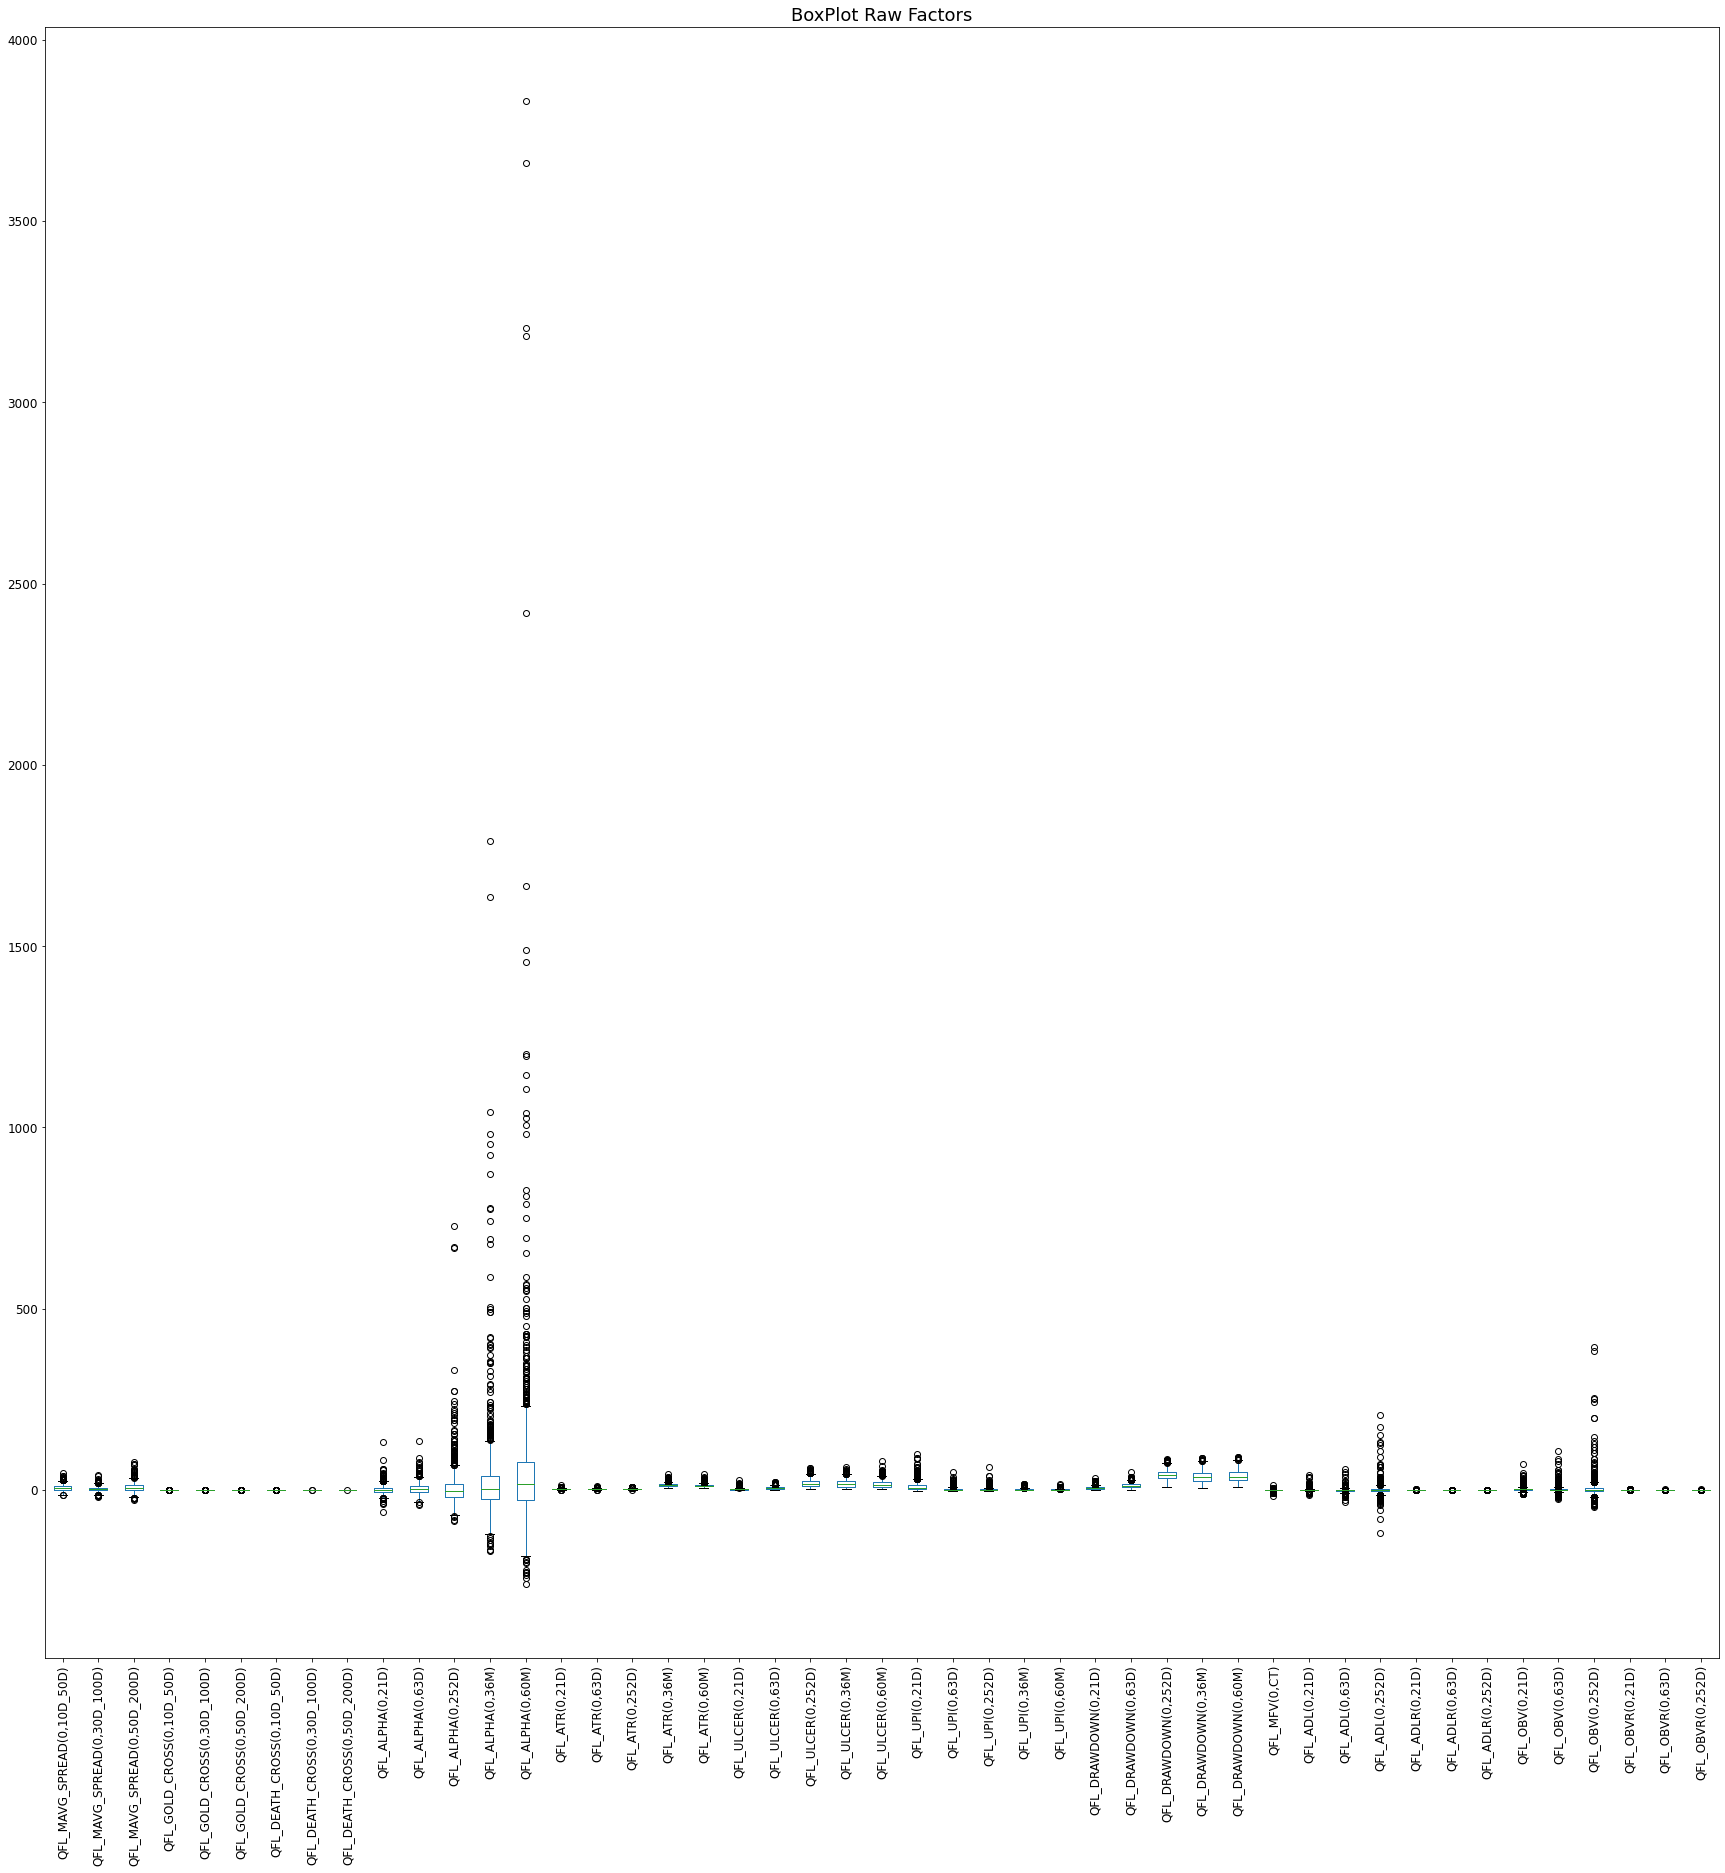

In [17]:
# Box-Whisker plot

qfl_df[qfl_df.columns[filter_idx]].boxplot(grid=False, rot=90, fontsize=12, figsize = (30,30)).set_title('BoxPlot Raw Factors', fontsize = 18);

In [18]:
# Z-Score

qfl_df_z = pd.DataFrame()

for factor in qfl_df[qfl_df.columns[filter_idx]]:
    z_score = ( qfl_df[factor] - qfl_df[factor].mean() ) / qfl_df[factor].std()
    qfl_df_z[factor] = z_score

qfl_df_z.describe()

,"QFL_MAVG_SPREAD(0,10D_50D)","QFL_MAVG_SPREAD(0,30D_100D)","QFL_MAVG_SPREAD(0,50D_200D)","QFL_GOLD_CROSS(0,10D_50D)","QFL_GOLD_CROSS(0,30D_100D)","QFL_GOLD_CROSS(0,50D_200D)","QFL_DEATH_CROSS(0,10D_50D)","QFL_DEATH_CROSS(0,30D_100D)","QFL_DEATH_CROSS(0,50D_200D)","QFL_ALPHA(0,21D)","QFL_ALPHA(0,63D)","QFL_ALPHA(0,252D)","QFL_ALPHA(0,36M)","QFL_ALPHA(0,60M)","QFL_ATR(0,21D)","QFL_ATR(0,63D)","QFL_ATR(0,252D)","QFL_ATR(0,36M)","QFL_ATR(0,60M)","QFL_ULCER(0,21D)","QFL_ULCER(0,63D)","QFL_ULCER(0,252D)","QFL_ULCER(0,36M)","QFL_ULCER(0,60M)","QFL_UPI(0,21D)","QFL_UPI(0,63D)","QFL_UPI(0,252D)","QFL_UPI(0,36M)","QFL_UPI(0,60M)","QFL_DRAWDOWN(0,21D)","QFL_DRAWDOWN(0,63D)","QFL_DRAWDOWN(0,252D)","QFL_DRAWDOWN(0,36M)","QFL_DRAWDOWN(0,60M)","QFL_MFV(0,CT)","QFL_ADL(0,21D)","QFL_ADL(0,63D)","QFL_ADL(0,252D)","QFL_ADLR(0,21D)","QFL_ADLR(0,63D)","QFL_ADLR(0,252D)","QFL_OBV(0,21D)","QFL_OBV(0,63D)","QFL_OBV(0,252D)","QFL_OBVR(0,21D)","QFL_OBVR(0,63D)","QFL_OBVR(0,252D)"
count,1.597000e+03,1.596000e+03,1.592000e+03,1.597000e+03,1.596000e+03,1.592000e+03,1.597000e+03,1.596000e+03,1.592000e+03,1.598000e+03,1.596000e+03,1.592000e+03,1.551000e+03,1.517000e+03,1.598000e+03,1.596000e+03,1.592000e+03,1.551000e+03,1.517000e+03,1.598000e+03,1.596000e+03,1.592000e+03,1.551000e+03,1.517000e+03,1.598000e+03,1.596000e+03,1.592000e+03,1.551000e+03,1.517000e+03,1.598000e+03,1.596000e+03,1.592000e+03,1.551000e+03,1.517000e+03,1.598000e+03,1.598000e+03,1.596000e+03,1.592000e+03,1.598000e+03,1.596000e+03,1.592000e+03,1.598000e+03,1.598000e+03,1.598000e+03,1.598000e+03,1.596000e+03,1.592000e+03
mean,-3.836074e-16,-9.460547e-18,-1.795186e-15,4.413084e-16,-6.650208e-16,-4.172054e-17,3.876395e-16,-9.899489e-16,5.150821e-16,-9.809981e-17,3.377972e-16,-1.145092e-16,-5.637728e-16,6.433000e-17,-4.934596e-15,4.402806e-15,-2.495073e-15,2.091851e-15,-3.103319e-15,1.616007e-16,-1.709855e-15,-1.823918e-15,4.039680e-16,-1.360641e-15,1.847222e-15,8.662661e-16,2.106076e-17,-1.266771e-15,-6.557415e-17,1.339076e-15,1.091580e-15,-1.417905e-15,-2.586252e-15,-9.051494e-16,8.632366e-17,5.303781e-16,-1.058747e-16,1.409049e-16,-3.769756e-16,5.801541e-17,3.535175e-16,1.450654e-16,1.802897e-16,-2.422621e-16,5.262791e-16,4.051340e-16,-1.074308e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.695032e+00,-3.415408e+00,-3.146049e+00,-8.325470e-02,-1.037283e-01,-1.007269e-01,-1.067356e-01,-3.541072e-02,-2.506274e-02,-5.818440e+00,-3.103040e+00,-1.860742e+00,-1.653019e+00,-1.296381e+00,-2.788445e+00,-2.958035e+00,-2.960316e+00,-2.194725e+00,-1.934270e+00,-1.191352e+00,-1.693952e+00,-1.693264e+00,-1.521054e+00,-1.451875e+00,-1.069687e+00,-1.102825e+00,-7.612269e-01,-8.647971e-01,-1.026760e+00,-1.630439e+00,-2.226173e+00,-2.673482e+00,-2.043343e+00,-1.880737e+00,-1.498848e+01,-5.098892e+00,-7.586755e+00,-8.333607e+00,-3.812003e+00,-8.225535e+00,-8.747817e+00,-2.990241e+00,-3.537159e+00,-2.173651e+00,-3.135909e+00,-2.750956e+00,-2.660523e+00
25%,-6.982753e-01,-6.637069e-01,-6.378844e-01,-8.325470e-02,-1.037283e-01,-1.007269e-01,-1.067356e-01,-3.541072e-02,-2.506274e-02,-5.875806e-01,-6.504548e-01,-4.751044e-01,-4.029671e-01,-3.519966e-01,-6.459138e-01,-6.524397e-01,-6.728754e-01,-6.869803e-01,-6.825461e-01,-6.250736e-01,-7.059586e-01,-7.831317e-01,-8.036067e-01,-7.705789e-01,-6.851027e-01,-6.448078e-01,-5.039651e-01,-5.939793e-01,-6.642920e-01,-6.924215e-01,-7.016787e-01,-7.301026e-01,-7.710148e-01,-7.866209e-01,-1.647710e-01,-3

In [19]:
# look for "extremely large" column's values after normalization (Descending)

for col_z in qfl_df_z:
    qfl_df_z[col_z] = qfl_df_z[col_z].sort_values(ignore_index=True, ascending = False)
    
qfl_df_z

,"QFL_MAVG_SPREAD(0,10D_50D)","QFL_MAVG_SPREAD(0,30D_100D)","QFL_MAVG_SPREAD(0,50D_200D)","QFL_GOLD_CROSS(0,10D_50D)","QFL_GOLD_CROSS(0,30D_100D)","QFL_GOLD_CROSS(0,50D_200D)","QFL_DEATH_CROSS(0,10D_50D)","QFL_DEATH_CROSS(0,30D_100D)","QFL_DEATH_CROSS(0,50D_200D)","QFL_ALPHA(0,21D)","QFL_ALPHA(0,63D)","QFL_ALPHA(0,252D)","QFL_ALPHA(0,36M)","QFL_ALPHA(0,60M)","QFL_ATR(0,21D)","QFL_ATR(0,63D)","QFL_ATR(0,252D)","QFL_ATR(0,36M)","QFL_ATR(0,60M)","QFL_ULCER(0,21D)","QFL_ULCER(0,63D)","QFL_ULCER(0,252D)","QFL_ULCER(0,36M)","QFL_ULCER(0,60M)","QFL_UPI(0,21D)","QFL_UPI(0,63D)","QFL_UPI(0,252D)","QFL_UPI(0,36M)","QFL_UPI(0,60M)","QFL_DRAWDOWN(0,21D)","QFL_DRAWDOWN(0,63D)","QFL_DRAWDOWN(0,252D)","QFL_DRAWDOWN(0,36M)","QFL_DRAWDOWN(0,60M)","QFL_MFV(0,CT)","QFL_ADL(0,21D)","QFL_ADL(0,63D)","QFL_ADL(0,252D)","QFL_ADLR(0,21D)","QFL_ADLR(0,63D)","QFL_ADLR(0,252D)","QFL_OBV(0,21D)","QFL_OBV(0,63D)","QFL_OBV(0,252D)","QFL_OBVR(0,21D)","QFL_OBVR(0,63D)","QFL_OBVR(0,252D)"
0,5.180979,6.205688,6.193076,12.003813,9.634529,9.921599,9.363081,28.222343,39.874812,12.134975,9.075609,15.169939,15.260256,15.541574,10.100468,10.328405,5.039662,7.548557,8.921085,10.083690,5.006486,4.275348,4.483145,6.766138,8.181488,11.836928,16.897744,7.155044,9.485471,7.120832,6.485436,3.415619,3.364889,3.362932,13.589370,13.560766,13.243034,14.306600,12.634984,17.010750,13.949331,14.850700,14.533066,16.425932,11.844991,17.306266,16.196171
1,4.255167,5.870075,5.765916,12.003813,9.634529,9.921599,9.363081,28.222343,-0.025063,7.452843,5.906084,13.995119,13.927605,14.835139,5.624909,4.991983,4.911737,5.971799,6.354287,7.234353,4.668266,4.156626,4.032672,5.383685,7.247880,8.267608,10.040291,7.007889,7.713139,5.052238,4.225237,3.369955,3.274025,3.357192,6.119155,11.821851,11.755422,12.157840,11.316554,11.384691,13.711832,9.541146,11.730003,15.949241,11.296581,11.827136,13.126918
2,4.062011,4.183348,5.750824,12.003813,9.634529,9.921599,9.363081,-0.035411,-0.025063,5.238186,5.224542,13.920829,8.826215,12.960964,5.425464,4.919380,4.903788,5.891900,5.552993,5.335444,4.501785,3.931297,3.649719,4.072757,7.121721,7.035054,9.846025,6.883267,4.692059,4.895481,4.096480,3.360319,3.270809,3.226450,5.194146,11.474072,10.352338,10.604392,10.501042,6.914585,8.659696,8.421646,10.683906,10.538215,10.325133,9.548069,10.791112
3,3.772081,3.911622,5.514389,12.003813,9.634529,9.921599,9.363081,-0.035411,-0.025063,5.166265,4.863694,6.879878,8.297630,12.877447,4.896294,4.435294,4.841136,5.312218,5.519867,5.325708,4.248025,3.670282,3.470490,3.932512,6.999365,6.428711,7.390138,6.509630,4.482318,4.832985,3.865064,3.321057,3.252863,3.135307,5.142614,11.063658,8.448357,9.227203,7.452494,5.524496,6.841261,8.095454,9.697408,10.443366,9.220994,7.805535,9.506855
4,3.557271,3.341073,4.538058,12.003813,9.634529,9.921599,9.363081,-0.035411,-0.025063,5.008372,4.569516,5.659702,8.046977,9.728438,4.806947,4.429877,4.574507,5.122365,5.107320,5.299617,4.219375,3.579888,3.420420,3.927109,5.776784,6.316597,5.990665,6.399704,4.405293,4.832961,3.860717,3.299311,3.052855,3.123130,5.045171,7.365414,6.046933,8.903187,7.243742,4.042214,6.621429,7.762941,7.454772,10.030300,8.574540,7.703383,9.414844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,-2.664891,-3.415408,NaN,-0.083255,-0.103728,NaN,-0.106736,-0.035411,NaN,-3.589154,-3.103040,NaN,NaN,NaN,-2.670206,-2.958035,NaN,NaN,NaN,-1.120065,-1.693952,NaN,NaN,NaN,-1.010073,-1.102825,NaN,NaN,NaN,-1.508790,-2.226173,NaN,NaN,NaN,-8.355709,-3.160883,-7.586755,NaN,-2.937368,-8.225535,NaN,-2.933207,-2.988233,-1.926996,-2.950493,-2.750956,NaN
1596,-2.695032,NaN,NaN,-0.083255,NaN,NaN,-0.106736,NaN,NaN,-3.830167,NaN,NaN,NaN,NaN,-2.681857,NaN,NaN,NaN,NaN,-1.138417,NaN,NaN,NaN,NaN,-1.027603,NaN,NaN,NaN,NaN,-1.542936,NaN,NaN,NaN,NaN,-8.357504,-3.873169,NaN,NaN,-3.664424,NaN,NaN,-2.954926,-3.110824,-2.075181,-2.954176,NaN,NaN
1597,NaN,NaN,Na

In [20]:
# look for "extremely large" column's values after normalization (Ascending)

for col_z in qfl_df_z:
    qfl_df_z[col_z] = qfl_df_z[col_z].sort_values(ignore_index=True, ascending = True)
    
qfl_df_z

,"QFL_MAVG_SPREAD(0,10D_50D)","QFL_MAVG_SPREAD(0,30D_100D)","QFL_MAVG_SPREAD(0,50D_200D)","QFL_GOLD_CROSS(0,10D_50D)","QFL_GOLD_CROSS(0,30D_100D)","QFL_GOLD_CROSS(0,50D_200D)","QFL_DEATH_CROSS(0,10D_50D)","QFL_DEATH_CROSS(0,30D_100D)","QFL_DEATH_CROSS(0,50D_200D)","QFL_ALPHA(0,21D)","QFL_ALPHA(0,63D)","QFL_ALPHA(0,252D)","QFL_ALPHA(0,36M)","QFL_ALPHA(0,60M)","QFL_ATR(0,21D)","QFL_ATR(0,63D)","QFL_ATR(0,252D)","QFL_ATR(0,36M)","QFL_ATR(0,60M)","QFL_ULCER(0,21D)","QFL_ULCER(0,63D)","QFL_ULCER(0,252D)","QFL_ULCER(0,36M)","QFL_ULCER(0,60M)","QFL_UPI(0,21D)","QFL_UPI(0,63D)","QFL_UPI(0,252D)","QFL_UPI(0,36M)","QFL_UPI(0,60M)","QFL_DRAWDOWN(0,21D)","QFL_DRAWDOWN(0,63D)","QFL_DRAWDOWN(0,252D)","QFL_DRAWDOWN(0,36M)","QFL_DRAWDOWN(0,60M)","QFL_MFV(0,CT)","QFL_ADL(0,21D)","QFL_ADL(0,63D)","QFL_ADL(0,252D)","QFL_ADLR(0,21D)","QFL_ADLR(0,63D)","QFL_ADLR(0,252D)","QFL_OBV(0,21D)","QFL_OBV(0,63D)","QFL_OBV(0,252D)","QFL_OBVR(0,21D)","QFL_OBVR(0,63D)","QFL_OBVR(0,252D)"
0,-2.695032,-3.415408,-3.146049,-0.083255,-0.103728,-0.100727,-0.106736,-0.035411,-0.025063,-5.818440,-3.103040,-1.860742,-1.653019,-1.296381,-2.788445,-2.958035,-2.960316,-2.194725,-1.934270,-1.191352,-1.693952,-1.693264,-1.521054,-1.451875,-1.069687,-1.102825,-0.761227,-0.864797,-1.026760,-1.630439,-2.226173,-2.673482,-2.043343,-1.880737,-14.988479,-5.098892,-7.586755,-8.333607,-3.812003,-8.225535,-8.747817,-2.990241,-3.537159,-2.173651,-3.135909,-2.750956,-2.660523
1,-2.664891,-3.132750,-2.790806,-0.083255,-0.103728,-0.100727,-0.106736,-0.035411,-0.025063,-3.830167,-2.837687,-1.824215,-1.629852,-1.232150,-2.681857,-2.888354,-2.367130,-1.839990,-1.902531,-1.138417,-1.649423,-1.629693,-1.486969,-1.399904,-1.027603,-1.100239,-0.755606,-0.858773,-1.016345,-1.542936,-2.068878,-2.414543,-1.918603,-1.874661,-8.357504,-3.873169,-6.069371,-5.651787,-3.664424,-7.253969,-5.324315,-2.954926,-3.110824,-2.075181,-2.954176,-2.509553,-2.614512
2,-2.580923,-2.918449,-2.677606,-0.083255,-0.103728,-0.100727,-0.106736,-0.035411,-0.025063,-3.589154,-2.511655,-1.634475,-1.608119,-1.203999,-2.670206,-2.367875,-2.305799,-1.802542,-1.805759,-1.120065,-1.568373,-1.564462,-1.469413,-1.399645,-1.010073,-1.093212,-0.744304,-0.857371,-1.005454,-1.508790,-1.966046,-2.326355,-1.879489,-1.797446,-8.355709,-3.160883,-4.477534,-3.912624,-2.937368,-6.353150,-3.091077,-2.933207,-2.988233,-1.926996,-2.950493,-2.473745,-1.996450
3,-2.575869,-2.910827,-2.599383,-0.083255,-0.103728,-0.100727,-0.106736,-0.035411,-0.025063,-3.413976,-2.434618,-1.612373,-1.534030,-1.174518,-2.381083,-2.161109,-2.011827,-1.798292,-1.728742,-1.084075,-1.549853,-1.533342,-1.462110,-1.399462,-0.994862,-1.084055,-0.741239,-0.837824,-0.981067,-1.469288,-1.900180,-2.194856,-1.854855,-1.788812,-7.680857,-2.997683,-4.190097,-2.958598,-2.503474,-4.310125,-3.036666,-2.893451,-2.914120,-1.926707,-2.789228,-2.422902,-1.974408
4,-2.558954,-2.851094,-2.494804,-0.083255,-0.103728,-0.100727,-0.106736,-0.035411,-0.025063,-2.997533,-2.407747,-1.529726,-1.476399,-1.162289,-2.229693,-1.998155,-1.966304,-1.797670,-1.708152,-1.082978,-1.530923,-1.499363,-1.457631,-1.394065,-0.986509,-1.083908,-0.740064,-0.830567,-0.975196,-1.456450,-1.879485,-2.153255,-1.834716,-1.768183,-7.318871,-2.840082,-3.889653,-2.715846,-2.484261,-3.822233,-2.655176,-2.786205,-2.623846,-1.922118,-2.562729,-2.402473,-1.931461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,4.255167,6.205688,NaN,12.003813,9.634529,NaN,9.363081,28.222343,NaN,5.238186,9.075609,NaN,NaN,NaN,5.425464,10.328405,NaN,NaN,NaN,5.335444,5.006486,NaN,NaN,NaN,7.121721,11.836928,NaN,NaN,NaN,4.895481,6.485436,NaN,NaN,NaN,5.194146,11.474072,13.243034,NaN,10.501042,17.010750,NaN,8.421646,10.683906,10.538215,10.325133,17.306266,NaN
1596,5.180979,NaN,NaN,12.003813,NaN,NaN,9.363081,NaN,NaN,7.452843,NaN,NaN,NaN,NaN,5.624909,NaN,NaN,NaN,NaN,7.234353,NaN,NaN,NaN,NaN,7.247880,N

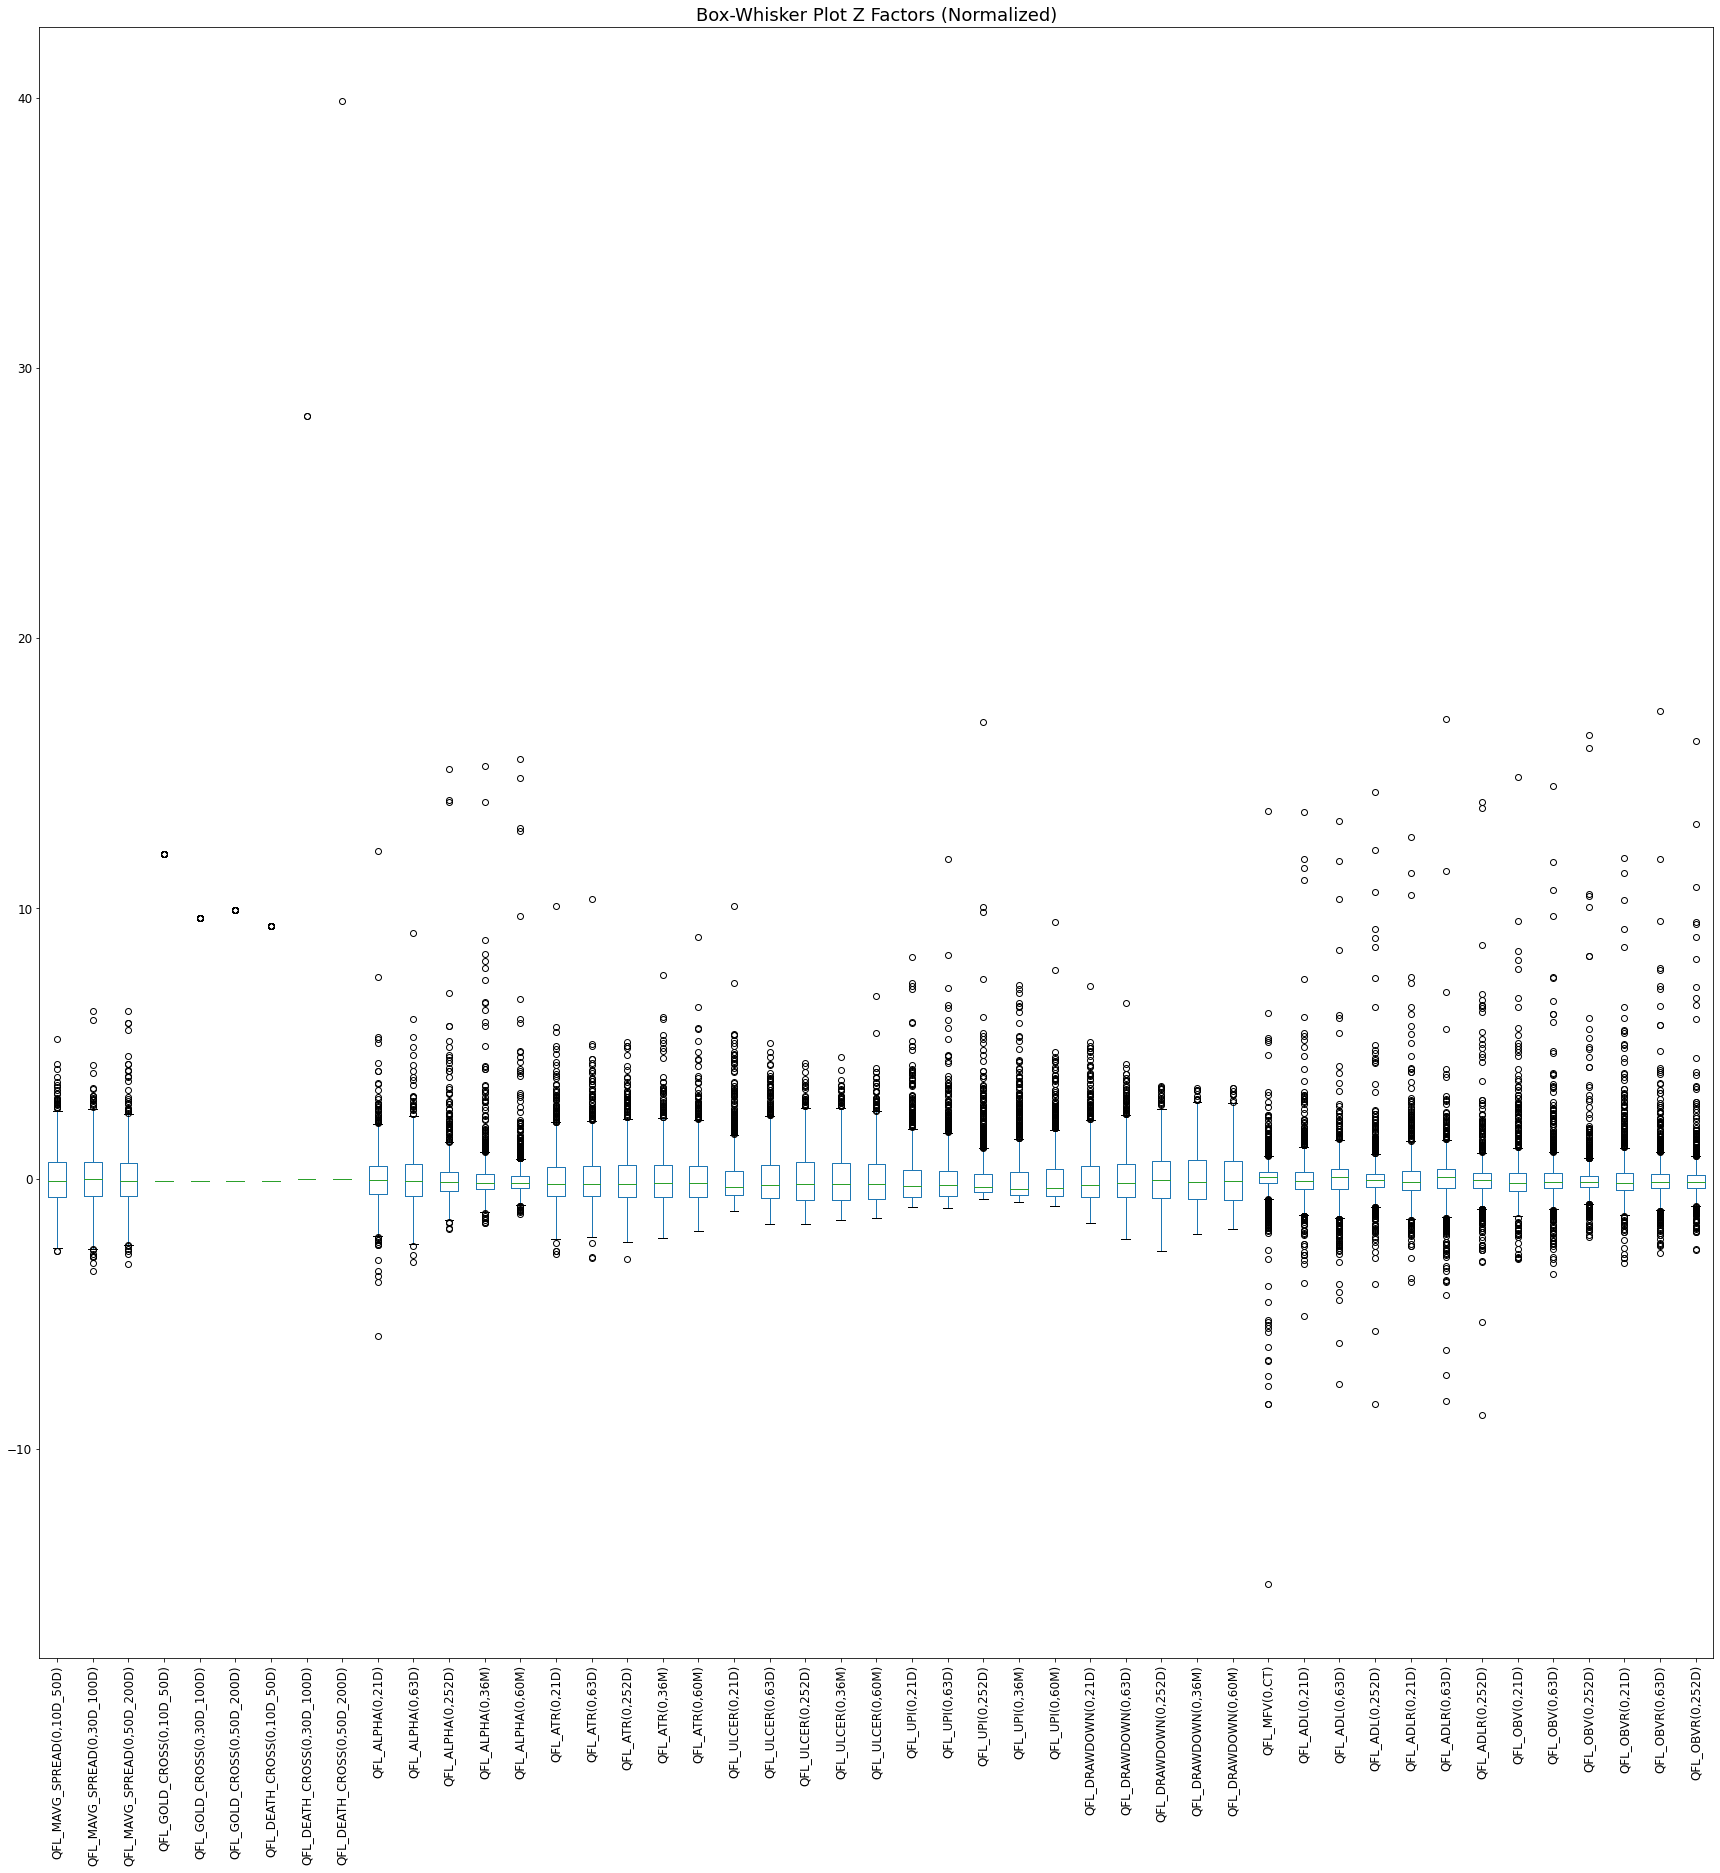

In [21]:
# Box-Whisker plot (Normalized data)

qfl_df_z.boxplot(grid=False, rot=90, fontsize=12, figsize = (30,30)).set_title('Box-Whisker Plot Z Factors (Normalized)', fontsize = 18);

In [22]:
# Greedy Multi-Factor Simple Average from all Multi-Factor's components

# MFR Z-Score

qfl_df_z['MFR'] = qfl_df_z.mean(axis = 1)

qfl_df_z.head()

,"QFL_MAVG_SPREAD(0,10D_50D)","QFL_MAVG_SPREAD(0,30D_100D)","QFL_MAVG_SPREAD(0,50D_200D)","QFL_GOLD_CROSS(0,10D_50D)","QFL_GOLD_CROSS(0,30D_100D)","QFL_GOLD_CROSS(0,50D_200D)","QFL_DEATH_CROSS(0,10D_50D)","QFL_DEATH_CROSS(0,30D_100D)","QFL_DEATH_CROSS(0,50D_200D)","QFL_ALPHA(0,21D)","QFL_ALPHA(0,63D)","QFL_ALPHA(0,252D)","QFL_ALPHA(0,36M)","QFL_ALPHA(0,60M)","QFL_ATR(0,21D)","QFL_ATR(0,63D)","QFL_ATR(0,252D)","QFL_ATR(0,36M)","QFL_ATR(0,60M)","QFL_ULCER(0,21D)","QFL_ULCER(0,63D)","QFL_ULCER(0,252D)","QFL_ULCER(0,36M)","QFL_ULCER(0,60M)","QFL_UPI(0,21D)","QFL_UPI(0,63D)","QFL_UPI(0,252D)","QFL_UPI(0,36M)","QFL_UPI(0,60M)","QFL_DRAWDOWN(0,21D)","QFL_DRAWDOWN(0,63D)","QFL_DRAWDOWN(0,252D)","QFL_DRAWDOWN(0,36M)","QFL_DRAWDOWN(0,60M)","QFL_MFV(0,CT)","QFL_ADL(0,21D)","QFL_ADL(0,63D)","QFL_ADL(0,252D)","QFL_ADLR(0,21D)","QFL_ADLR(0,63D)","QFL_ADLR(0,252D)","QFL_OBV(0,21D)","QFL_OBV(0,63D)","QFL_OBV(0,252D)","QFL_OBVR(0,21D)","QFL_OBVR(0,63D)","QFL_OBVR(0,252D)",MFR
0,-2.695032,-3.415408,-3.146049,-0.083255,-0.103728,-0.100727,-0.106736,-0.035411,-0.025063,-5.818440,-3.103040,-1.860742,-1.653019,-1.296381,-2.788445,-2.958035,-2.960316,-2.194725,-1.934270,-1.191352,-1.693952,-1.693264,-1.521054,-1.451875,-1.069687,-1.102825,-0.761227,-0.864797,-1.026760,-1.630439,-2.226173,-2.673482,-2.043343,-1.880737,-14.988479,-5.098892,-7.586755,-8.333607,-3.812003,-8.225535,-8.747817,-2.990241,-3.537159,-2.173651,-3.135909,-2.750956,-2.660523,-2.833007
1,-2.664891,-3.132750,-2.790806,-0.083255,-0.103728,-0.100727,-0.106736,-0.035411,-0.025063,-3.830167,-2.837687,-1.824215,-1.629852,-1.232150,-2.681857,-2.888354,-2.367130,-1.839990,-1.902531,-1.138417,-1.649423,-1.629693,-1.486969,-1.399904,-1.027603,-1.100239,-0.755606,-0.858773,-1.016345,-1.542936,-2.068878,-2.414543,-1.918603,-1.874661,-8.357504,-3.873169,-6.069371,-5.651787,-3.664424,-7.253969,-5.324315,-2.954926,-3.110824,-2.075181,-2.954176,-2.509553,-2.614512,-2.348375
2,-2.580923,-2.918449,-2.677606,-0.083255,-0.103728,-0.100727,-0.106736,-0.035411,-0.025063,-3.589154,-2.511655,-1.634475,-1.608119,-1.203999,-2.670206,-2.367875,-2.305799,-1.802542,-1.805759,-1.120065,-1.568373,-1.564462,-1.469413,-1.399645,-1.010073,-1.093212,-0.744304,-0.857371,-1.005454,-1.508790,-1.966046,-2.326355,-1.879489,-1.797446,-8.355709,-3.160883,-4.477534,-3.912624,-2.937368,-6.353150,-3.091077,-2.933207,-2.988233,-1.926996,-2.950493,-2.473745,-1.996450,-2.106371
3,-2.575869,-2.910827,-2.599383,-0.083255,-0.103728,-0.100727,-0.106736,-0.035411,-0.025063,-3.413976,-2.434618,-1.612373,-1.534030,-1.174518,-2.381083,-2.161109,-2.011827,-1.798292,-1.728742,-1.084075,-1.549853,-1.533342,-1.462110,-1.399462,-0.994862,-1.084055,-0.741239,-0.837824,-0.981067,-1.469288,-1.900180,-2.194856,-1.854855,-1.788812,-7.680857,-2.997683,-4.190097,-2.958598,-2.503474,-4.310125,-3.036666,-2.893451,-2.914120,-1.926707,-2.789228,-2.422902,-1.974408,-1.963101
4,-2.558954,-2.851094,-2.494804,-0.083255,-0.103728,-0.100727,-0.106736,-0.035411,-0.025063,-2.997533,-2.407747,-1.529726,-1.476399,-1.162289,-2.229693,-1.998155,-1.966304,-1.797670,-1.708152,-1.082978,-1.530923,-1.499363,-1.457631,-1.394065,-0.986509,-1.083908,-0.740064,-0.830567,-0.975196,-1.456450,-1.879485,-2.153255,-1.834716,-1.768183,-7.318871,-2.840082,-3.889653,-2.715846,-2.484261,-3.822233,-2.655176,-2.786205,-2.623846,-1.922118,-2.562729,-2.402473,-1.931461,-1.877908


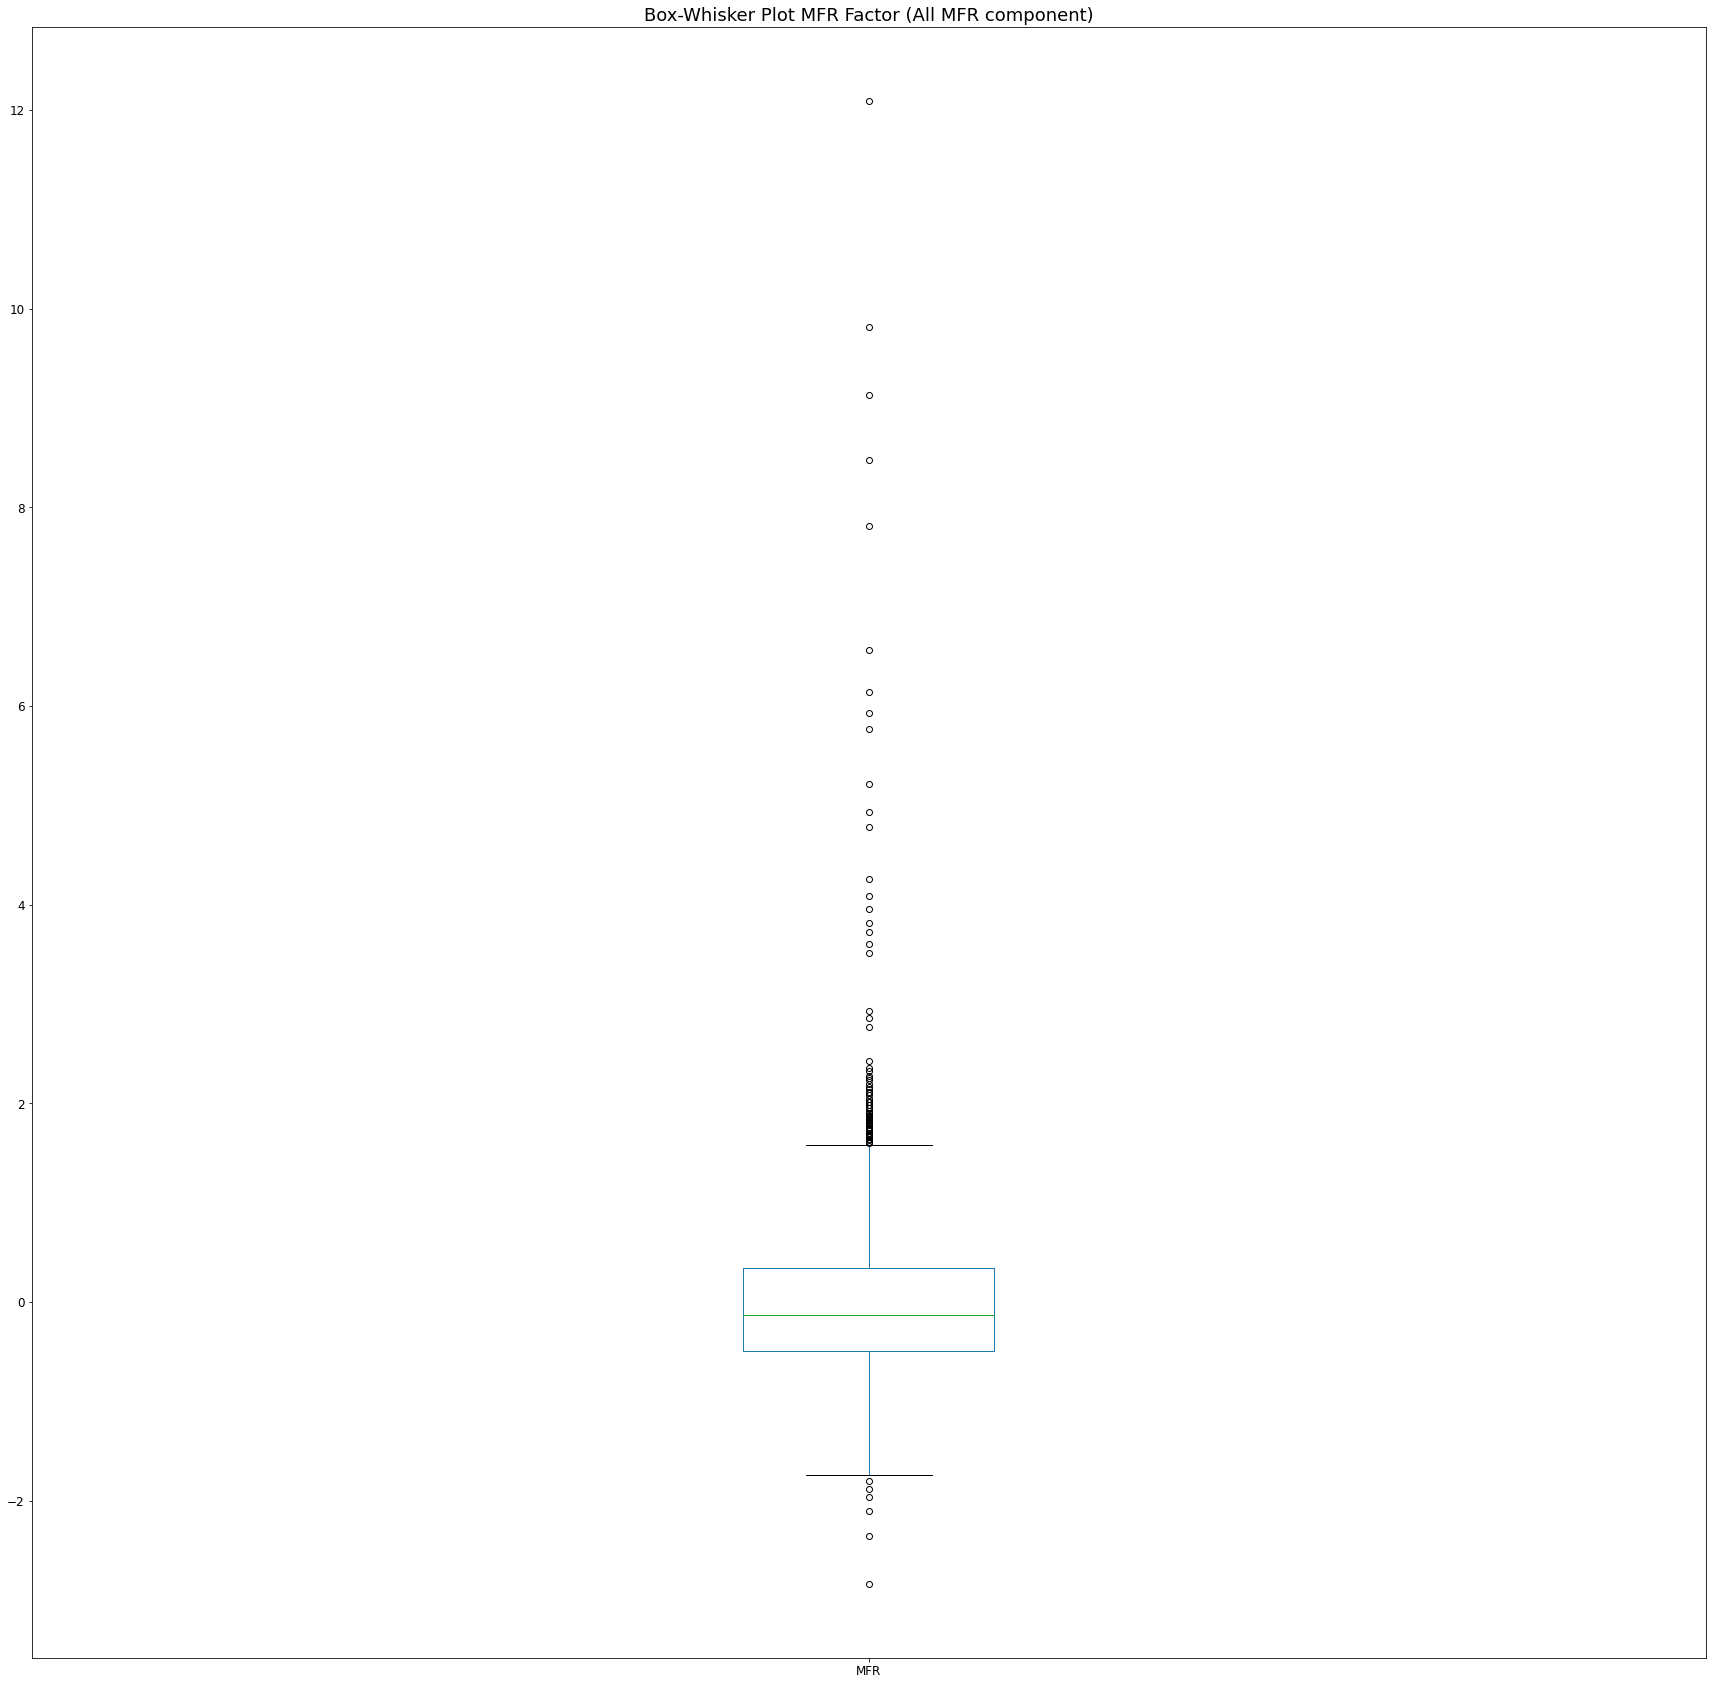

In [23]:
pd.DataFrame(qfl_df_z['MFR']).boxplot(grid=False, fontsize=12, figsize = (30,30)).set_title('Box-Whisker Plot MFR Factor (All MFR component)', fontsize = 18);

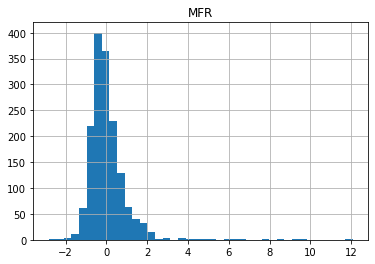

In [24]:
# MFR Distribution

pd.DataFrame(qfl_df_z['MFR']).hist(bins = int(np.sqrt(len(qfl_df_z['MFR']))));

In [25]:
# Check Infomation Coefficient: MFR (Components: All, Z-Scored Only)

sp_corr_z, sp_pval_z = stats.spearmanr(-qfl_df_z['MFR'].replace(np.nan, 0), qfl_df['p_total_return'].replace(np.nan, 0))
print('Information Coefficient: {0}'.format(round(sp_corr_z,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z,2)))

Information Coefficient: 0.05
Information Coefficient (P-Value): 0.04


C:\Users\ffais\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


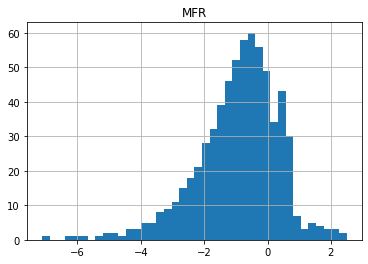

In [26]:
# MFR Log-Distribution

pd.DataFrame(np.log(qfl_df_z['MFR'])).hist(bins = int(np.sqrt(len(qfl_df_z['MFR']))));

In [27]:
# Log-Transformation for positive/not-zero features

qfl_df_log = pd.DataFrame()

for col_pos in qfl_df[qfl_df.columns[filter_idx]]:
    if np.sum(qfl_df[qfl_df.columns[filter_idx]][col_pos] <= 0) == 0:
        qfl_df_log[col_pos] = np.log(qfl_df[qfl_df.columns[filter_idx]][col_pos])
    else:
        qfl_df_log[col_pos] = qfl_df[qfl_df.columns[filter_idx]][col_pos]
    
qfl_df_log

,"QFL_MAVG_SPREAD(0,10D_50D)","QFL_MAVG_SPREAD(0,30D_100D)","QFL_MAVG_SPREAD(0,50D_200D)","QFL_GOLD_CROSS(0,10D_50D)","QFL_GOLD_CROSS(0,30D_100D)","QFL_GOLD_CROSS(0,50D_200D)","QFL_DEATH_CROSS(0,10D_50D)","QFL_DEATH_CROSS(0,30D_100D)","QFL_DEATH_CROSS(0,50D_200D)","QFL_ALPHA(0,21D)","QFL_ALPHA(0,63D)","QFL_ALPHA(0,252D)","QFL_ALPHA(0,36M)","QFL_ALPHA(0,60M)","QFL_ATR(0,21D)","QFL_ATR(0,63D)","QFL_ATR(0,252D)","QFL_ATR(0,36M)","QFL_ATR(0,60M)","QFL_ULCER(0,21D)","QFL_ULCER(0,63D)","QFL_ULCER(0,252D)","QFL_ULCER(0,36M)","QFL_ULCER(0,60M)","QFL_UPI(0,21D)","QFL_UPI(0,63D)","QFL_UPI(0,252D)","QFL_UPI(0,36M)","QFL_UPI(0,60M)","QFL_DRAWDOWN(0,21D)","QFL_DRAWDOWN(0,63D)","QFL_DRAWDOWN(0,252D)","QFL_DRAWDOWN(0,36M)","QFL_DRAWDOWN(0,60M)","QFL_MFV(0,CT)","QFL_ADL(0,21D)","QFL_ADL(0,63D)","QFL_ADL(0,252D)","QFL_ADLR(0,21D)","QFL_ADLR(0,63D)","QFL_ADLR(0,252D)","QFL_OBV(0,21D)","QFL_OBV(0,63D)","QFL_OBV(0,252D)","QFL_OBVR(0,21D)","QFL_OBVR(0,63D)","QFL_OBVR(0,252D)"
0,0.908422,2.190924,22.300552,0.0,0.0,0.0,0.0,0.0,0.0,0.282931,-11.076964,60.618600,134.482420,214.451050,0.937286,1.296161,1.200870,2.730391,2.571338,0.805371,2.507897,2.399841,2.429121,2.355109,4.267644,-0.752724,6.951158,3.643182,3.119152,1.679261,2.928043,3.447676,3.418027,3.418027,0.076650,0.468663,-3.214661,15.559433,-0.003685,-0.018809,0.069058,0.897733,-0.483903,10.278099,-0.027450,-0.018710,0.051649
1,0.193012,0.673807,9.430277,0.0,0.0,0.0,0.0,0.0,0.0,-7.456026,-8.933098,24.984148,128.761020,244.851440,0.898844,1.062540,1.102194,2.439047,2.301363,1.325232,2.204768,2.136026,1.425108,1.369722,1.595996,-0.810231,4.850116,9.066426,8.287066,1.763762,2.602282,3.333628,2.473119,2.473119,0.283574,0.228491,-0.827233,6.424770,-0.019273,-0.004223,0.029779,0.310049,-0.075904,9.723318,0.000387,0.047202,0.042911
2,-1.113510,-0.660509,15.358949,0.0,0.0,0.0,0.0,0.0,0.0,-6.164508,-11.868568,70.193710,128.254990,289.742830,1.028995,1.243581,1.129025,2.668305,2.548624,1.635319,2.365786,1.999393,2.257196,2.150679,0.846603,-0.966041,10.829136,4.092957,4.266623,2.156260,2.792751,3.124332,3.266129,3.266129,-0.140661,0.175216,-2.166270,11.483603,-0.033030,-0.011937,0.068943,0.115145,-5.485584,26.190533,0.020988,-0.004588,0.126230
3,1.323950,3.795648,15.742278,0.0,0.0,0.0,0.0,0.0,0.0,-10.125097,-9.971259,26.578670,8.150616,78.190346,1.106982,1.234314,1.255414,2.733574,2.568970,1.776049,2.420362,2.491872,2.472869,2.246170,0.891863,-0.750198,3.374127,1.354318,2.283761,2.186945,2.888533,3.543626,3.448503,3.448503,0.542860,2.111987,-1.672756,17.121756,0.076933,-0.021562,0.069752,-2.098329,-7.116575,29.107930,-0.127555,-0.010739,0.157323
4,8.886969,7.639766,11.351240,0.0,0.0,0.0,0.0,0.0,0.0,-4.438792,0.437721,16.877655,32.805202,58.541954,0.804396,1.076828,1.054711,2.514104,2.382212,0.063477,2.303556,2.399310,2.087296,1.921319,8.089769,0.187634,2.759648,2.468466,2.759453,0.959908,2.896714,3.427194,3.055238,3.055238,-0.360936,-1.380326,-3.656611,6.309656,-0.069573,-0.032374,0.039133,2.033520,3.476768,15.274876,0.010897,0.158420,0.065758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,11.678183,7.621849,2.444029,0.0,0.0,0.0,0.0,0.0,0.0,-4.092777,13.512959,-17.561626,-7.142017,-28.724890,1.125201,0.985224,1.240681,2.257750,2.125708,0.492438,1.329735,3.358475,2.894437,2.836938,9.240067,4.372513,-0.556519,0.024382,0.031647,1.145379,2.160296,3.970924,3.776280,3.776280,1.520799,2.229793,0.473948,-0.928018,0.033417,-0.005363,-0.014788,-2.157947,-3.800763,-6.386661,0.029716,0.015417,-0.019087
1596,-5.886621,-6.623697,-9.362716,0.0,0.0,0.0,0.0,0.0,0.0,-11.464783,-20.298260,-34.205807,-29.312151,-58.214480,0.823078,0.692590,0.930364,2.376991,2.450550,1.857700,1.876964,3.062745,2.957149,3.494093,-0.709232,-1.798955,-1.470330,-0.558665,-0.379892,2.286711,2.559375,3.531379,3.592714,3.921546,0.398857,-1.640006,-5.091897,-8.518397,-0.072990,-0.077047,-0.030194,-0.38

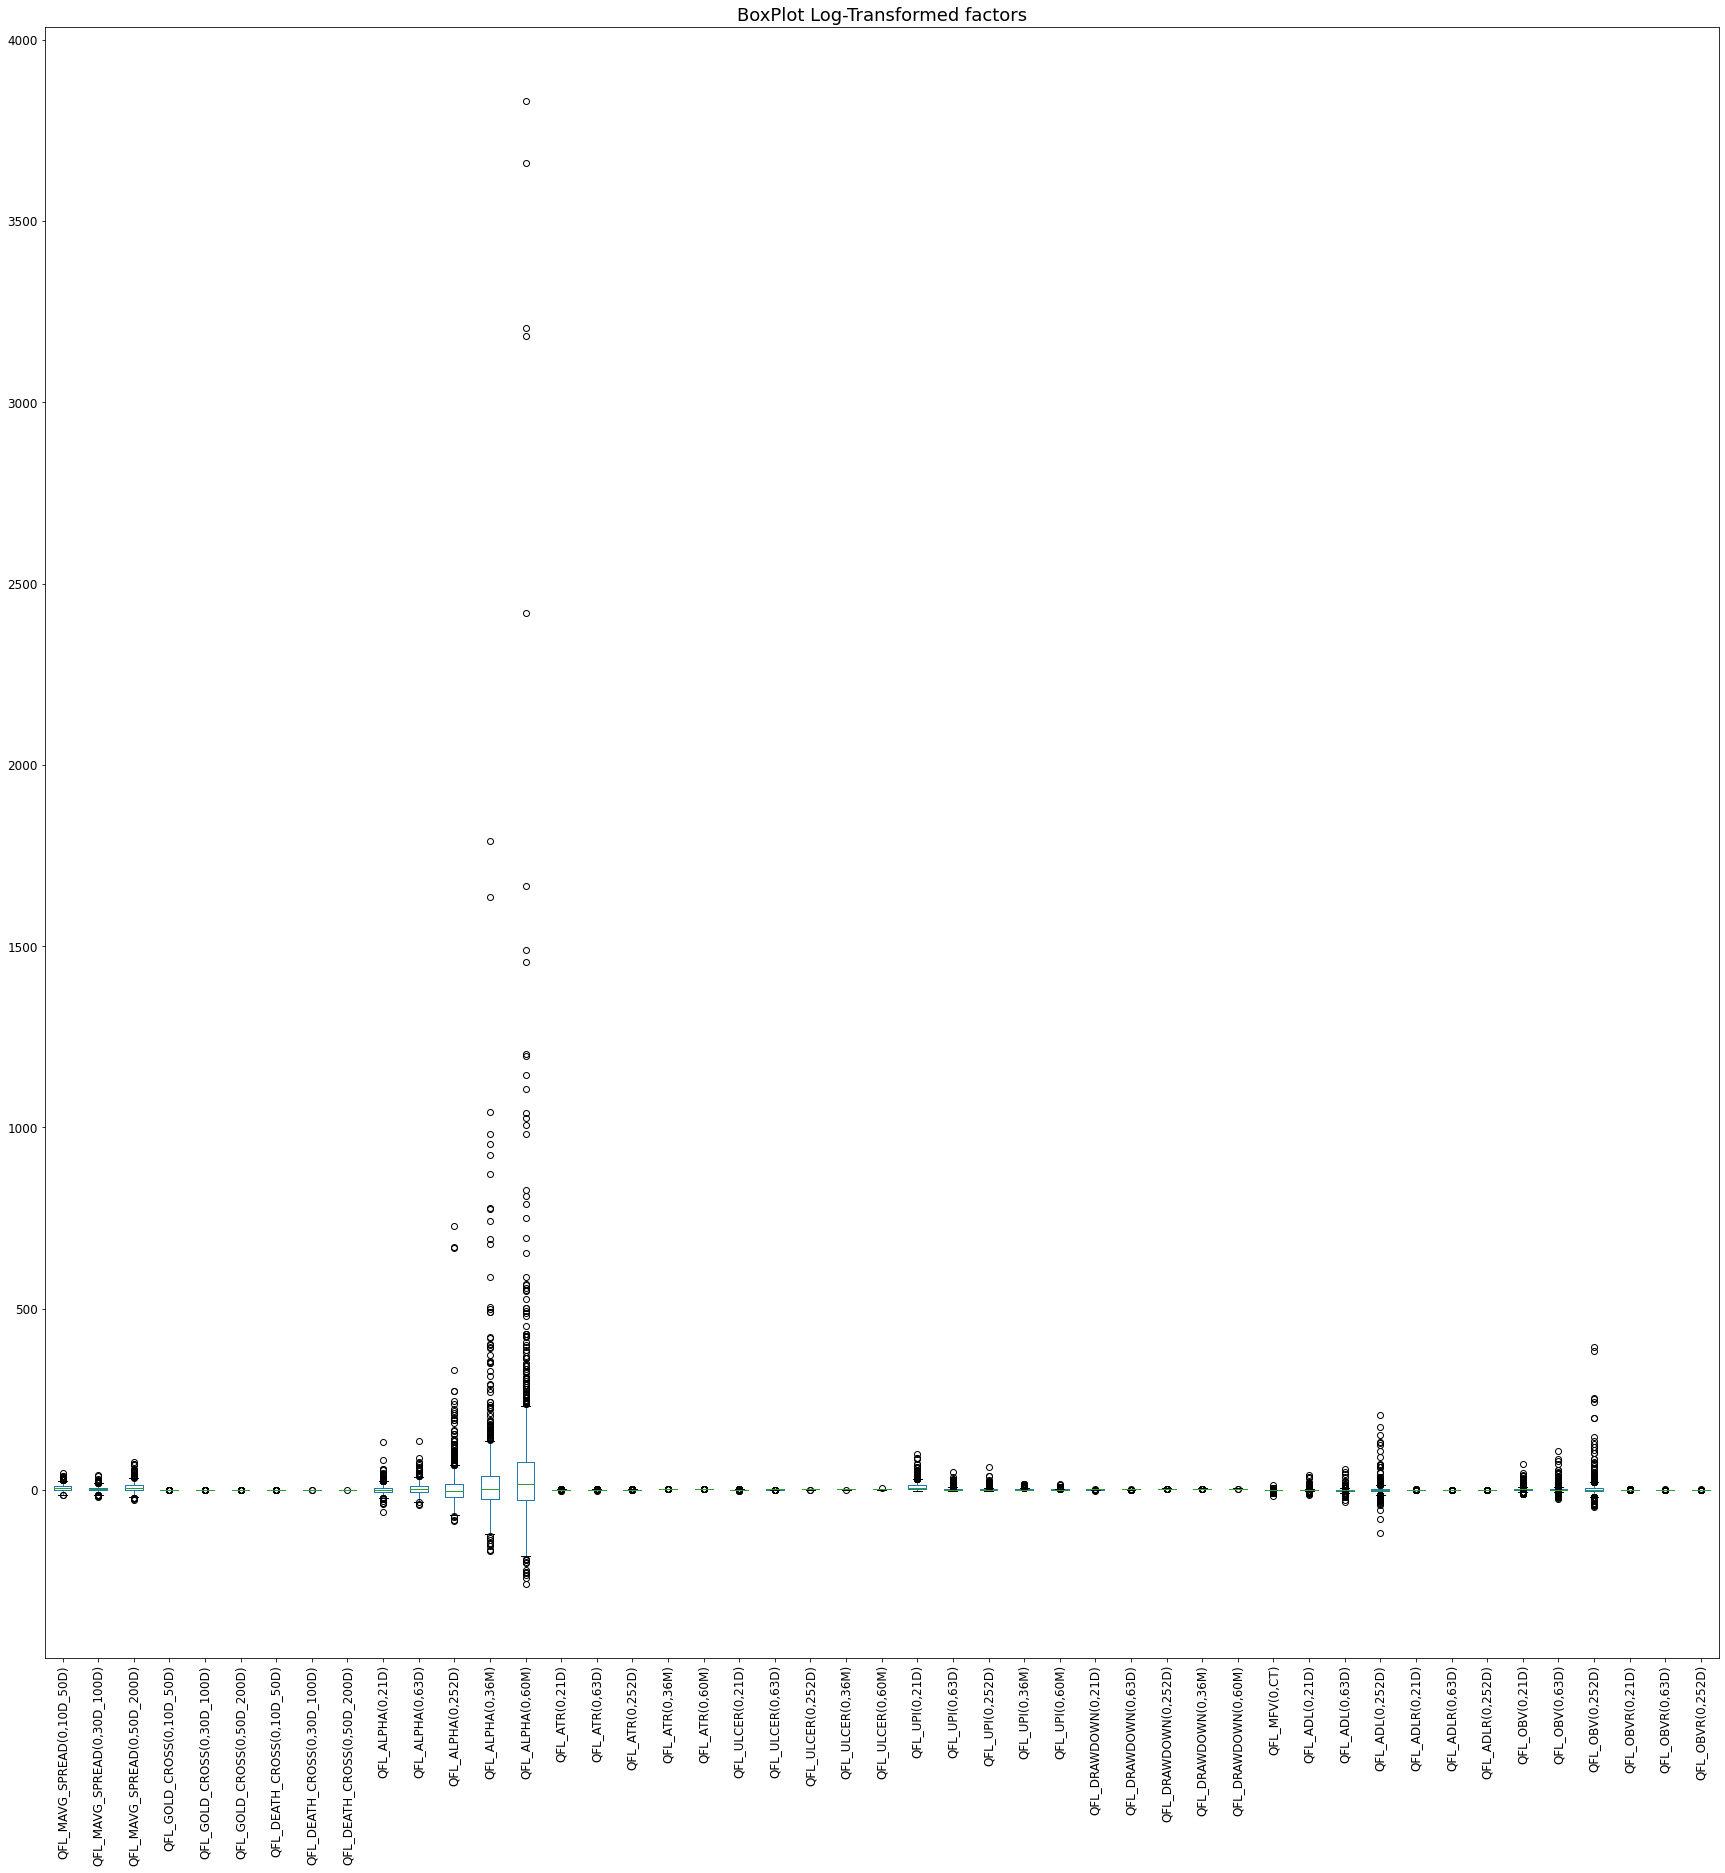

In [28]:
# Box-Whisker plot of Log-Transformed data

qfl_df_log.boxplot(grid=False, rot=90, fontsize=12, figsize = (30,30)).set_title('BoxPlot Log-Transformed factors', fontsize = 18);

In [29]:
# MFR Z-Score of Log-Transformed and Z-Scored data

# Z-Score of Log-Transformed data

qfl_df_log_z = pd.DataFrame()

for factor in qfl_df_log:
    z_score = ( qfl_df_log[factor] - qfl_df_log[factor].mean() ) / qfl_df_log[factor].std()
    qfl_df_log_z[factor] = z_score

qfl_df_log_z['MFR'] = qfl_df_log_z.mean(axis = 1)

qfl_df_log_z.head()

,"QFL_MAVG_SPREAD(0,10D_50D)","QFL_MAVG_SPREAD(0,30D_100D)","QFL_MAVG_SPREAD(0,50D_200D)","QFL_GOLD_CROSS(0,10D_50D)","QFL_GOLD_CROSS(0,30D_100D)","QFL_GOLD_CROSS(0,50D_200D)","QFL_DEATH_CROSS(0,10D_50D)","QFL_DEATH_CROSS(0,30D_100D)","QFL_DEATH_CROSS(0,50D_200D)","QFL_ALPHA(0,21D)","QFL_ALPHA(0,63D)","QFL_ALPHA(0,252D)","QFL_ALPHA(0,36M)","QFL_ALPHA(0,60M)","QFL_ATR(0,21D)","QFL_ATR(0,63D)","QFL_ATR(0,252D)","QFL_ATR(0,36M)","QFL_ATR(0,60M)","QFL_ULCER(0,21D)","QFL_ULCER(0,63D)","QFL_ULCER(0,252D)","QFL_ULCER(0,36M)","QFL_ULCER(0,60M)","QFL_UPI(0,21D)","QFL_UPI(0,63D)","QFL_UPI(0,252D)","QFL_UPI(0,36M)","QFL_UPI(0,60M)","QFL_DRAWDOWN(0,21D)","QFL_DRAWDOWN(0,63D)","QFL_DRAWDOWN(0,252D)","QFL_DRAWDOWN(0,36M)","QFL_DRAWDOWN(0,60M)","QFL_MFV(0,CT)","QFL_ADL(0,21D)","QFL_ADL(0,63D)","QFL_ADL(0,252D)","QFL_ADLR(0,21D)","QFL_ADLR(0,63D)","QFL_ADLR(0,252D)","QFL_OBV(0,21D)","QFL_OBV(0,63D)","QFL_OBV(0,252D)","QFL_OBVR(0,21D)","QFL_OBVR(0,63D)","QFL_OBVR(0,252D)",MFR
0,-0.712312,-0.127837,1.366373,-0.083255,-0.103728,-0.100727,-0.106736,-0.035411,-0.025063,-0.153379,-1.003049,1.179676,0.971200,0.648576,-0.666373,0.825797,-0.114702,0.542353,0.260207,-0.033399,1.538678,-0.842236,-0.476254,-0.534236,-0.461590,-0.819786,1.498949,1.129953,1.196139,-0.001815,1.005705,-0.703268,-0.217138,-0.357328,0.097720,-0.087650,-0.624402,1.013350,-0.293654,-0.160158,1.090151,-0.315403,-0.283209,0.263906,-0.561663,-0.439823,0.387795,0.097254
1,-0.804425,-0.368093,0.216033,-0.083255,-0.103728,-0.100727,-0.106736,-0.035411,-0.025063,-0.869754,-0.854301,0.431904,0.921780,0.773764,-0.783516,0.016346,-0.497618,-0.580424,-0.790492,0.697221,0.945235,-1.351983,-2.151822,-2.283834,-0.705340,-0.834312,0.936470,3.579695,4.334525,0.142020,0.224213,-1.058972,-2.312529,-2.570138,0.281852,-0.167745,-0.080780,0.375694,-0.403121,0.051344,0.439158,-0.442880,-0.227155,0.240530,-0.447621,0.098777,0.298253,-0.128446
2,-0.972647,-0.579399,0.745935,-0.083255,-0.103728,-0.100727,-0.106736,-0.035411,-0.025063,-0.750201,-1.057972,1.380605,0.917409,0.958626,-0.386910,0.643618,-0.393501,0.303087,0.171810,1.133021,1.260465,-1.615988,-0.763175,-0.897211,-0.773711,-0.873668,2.537141,1.333122,1.892979,0.810116,0.681143,-1.711741,-0.553981,-0.713047,-0.095655,-0.185512,-0.385681,0.728831,-0.499730,-0.060512,1.088245,-0.485158,-0.970372,0.934382,-0.363224,-0.324425,1.152058,0.059665
3,-0.658810,0.126292,0.780197,-0.083255,-0.103728,-0.100727,-0.106736,-0.035411,-0.025063,-1.116823,-0.926332,0.465364,-0.120029,0.087456,-0.149259,0.611507,0.096957,0.554620,0.250993,1.330805,1.367309,-0.664412,-0.403245,-0.727661,-0.769582,-0.819148,0.541326,0.096046,0.688821,0.862348,0.910923,-0.404011,-0.149555,-0.285958,0.512579,0.460382,-0.273307,1.122409,0.272488,-0.200077,1.101653,-0.965292,-1.194448,1.057308,-0.971771,-0.374688,1.470680,0.066790
4,0.314970,0.735058,0.387728,-0.083255,-0.103728,-0.100727,-0.106736,-0.035411,-0.025063,-0.590456,-0.204129,0.261793,0.092933,0.006544,-1.071328,0.065850,-0.681880,-0.291172,-0.475842,-1.076066,1.138636,-0.843262,-1.046716,-1.304450,-0.112876,-0.582260,0.376821,0.599320,0.977700,-1.226273,0.930549,-0.767148,-1.021644,-1.206916,-0.291668,-0.704269,-0.725035,0.367658,-0.756354,-0.356855,0.594187,-0.069035,0.260934,0.474447,-0.404564,1.007597,0.532376,-0.151915


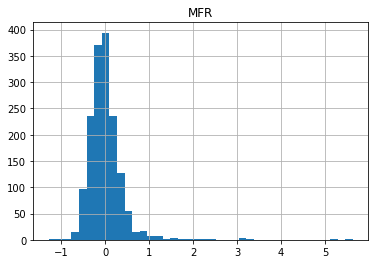

In [30]:
# MFR Distribution (of Log-Transformed and Z-Score factors)

pd.DataFrame(qfl_df_log_z['MFR']).hist(bins = int(np.sqrt(len(qfl_df_log_z['MFR']))));

In [31]:
# Check Infomation Coefficient: MRF (Components: All, Z-Scored & Log-Transformed)

sp_corr_z_log, sp_pval_z_log = stats.spearmanr(-qfl_df_log_z['MFR'].replace(np.nan, 0), qfl_df['p_total_return'].replace(np.nan, 0))
print('Information Coefficient: {0}'.format(round(sp_corr_z_log,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z_log,2)))

Information Coefficient: -0.19
Information Coefficient (P-Value): 0.0


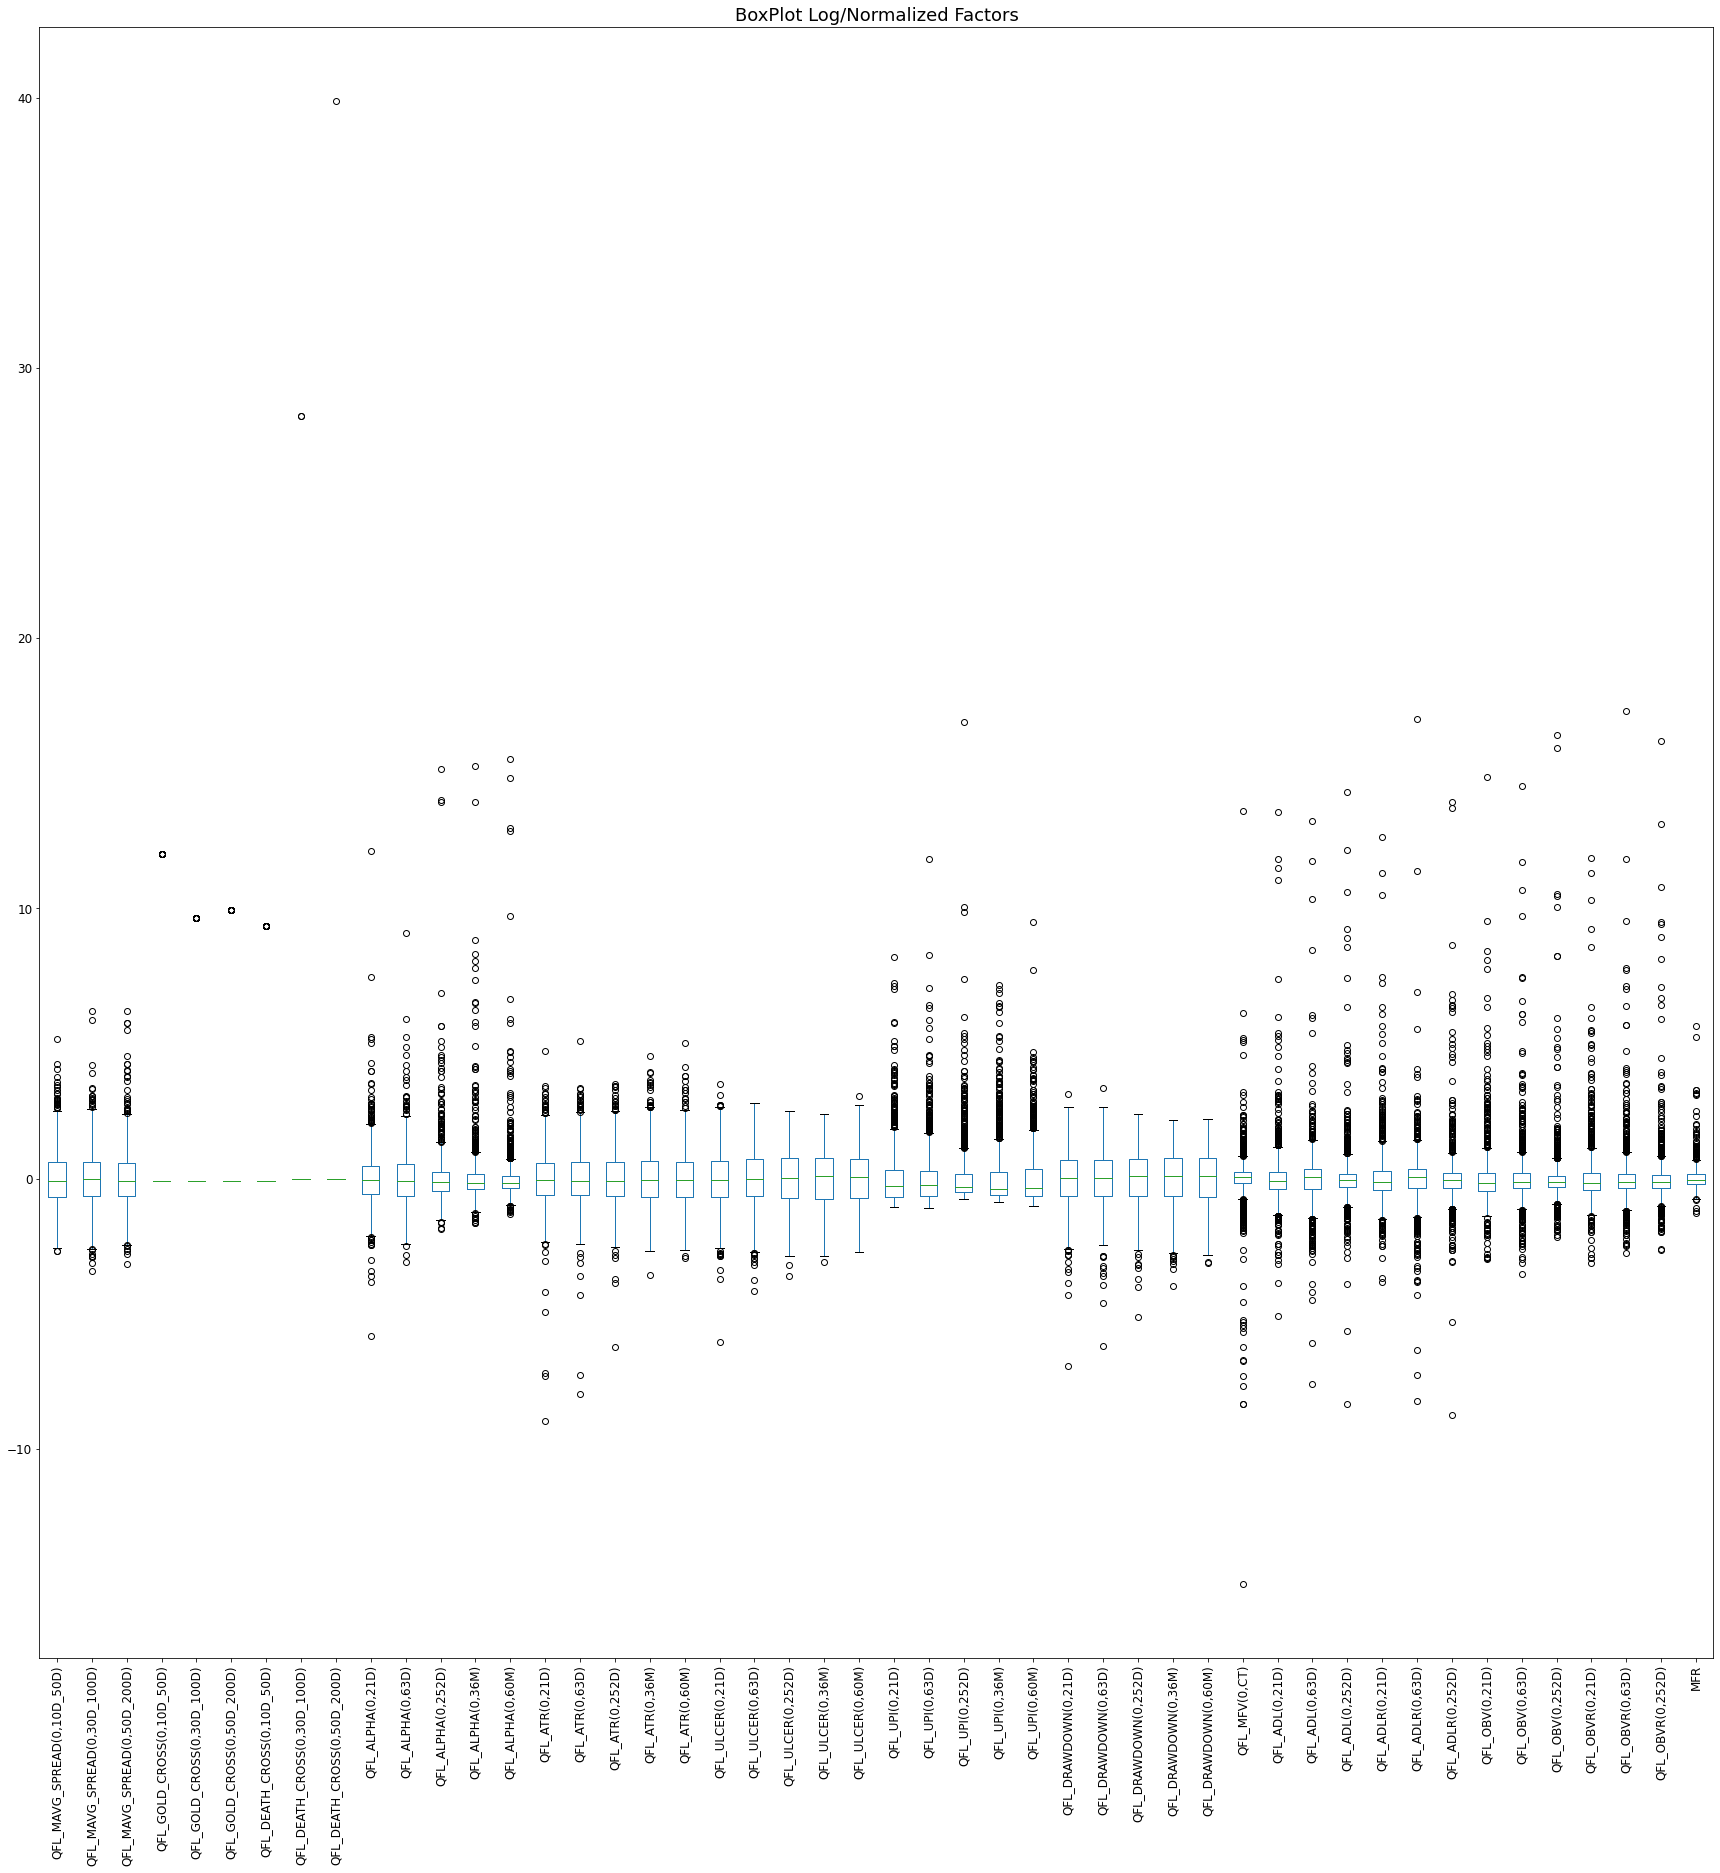

In [32]:
# Box-Whisker plot of Log-Transformed and Z-Score data

qfl_df_log_z.boxplot(grid=False, rot=90, fontsize=12, figsize = (30,30)).set_title('BoxPlot Log/Normalized Factors', fontsize = 18);

In [33]:
# Check Universe Exposures (Geography, Size, Sector)

qfl_df['ison_screen'] = 1

qfl_df.head()

,BENCHMARK_ID,DATE,SECURITY_ID,Weight,proper_name,fg_gics_sector,proper,p_total_return,qfl_size_class,qfl_mkt_val_sec,"QFL_MAVG_SPREAD(0,10D_50D)","QFL_MAVG_SPREAD(0,30D_100D)","QFL_MAVG_SPREAD(0,50D_200D)","QFL_GOLD_CROSS(0,10D_50D)","QFL_GOLD_CROSS(0,30D_100D)","QFL_GOLD_CROSS(0,50D_200D)","QFL_DEATH_CROSS(0,10D_50D)","QFL_DEATH_CROSS(0,30D_100D)","QFL_DEATH_CROSS(0,50D_200D)","QFL_ALPHA(0,21D)","QFL_ALPHA(0,63D)","QFL_ALPHA(0,252D)","QFL_ALPHA(0,36M)","QFL_ALPHA(0,60M)","QFL_ATR(0,21D)","QFL_ATR(0,63D)","QFL_ATR(0,252D)","QFL_ATR(0,36M)","QFL_ATR(0,60M)","QFL_ULCER(0,21D)","QFL_ULCER(0,63D)","QFL_ULCER(0,252D)","QFL_ULCER(0,36M)","QFL_ULCER(0,60M)","QFL_UPI(0,21D)","QFL_UPI(0,63D)","QFL_UPI(0,252D)","QFL_UPI(0,36M)","QFL_UPI(0,60M)","QFL_DRAWDOWN(0,21D)","QFL_DRAWDOWN(0,63D)","QFL_DRAWDOWN(0,252D)","QFL_DRAWDOWN(0,36M)","QFL_DRAWDOWN(0,60M)","QFL_MFV(0,CT)","QFL_ADL(0,21D)","QFL_ADL(0,63D)","QFL_ADL(0,252D)","QFL_ADLR(0,21D)","QFL_ADLR(0,63D)","QFL_ADLR(0,252D)","QFL_OBV(0,21D)","QFL_OBV(0,63D)","QFL_OBV(0,252D)","QFL_OBVR(0,21D)","QFL_OBVR(0,63D)","QFL_OBVR(0,252D)",ison_screen
0,890100,30-Nov-2020,03783310,4.204100,Apple Inc.,Information Technology,United States,11.457372,Mega Cap,2024064.4,0.908422,2.190924,22.300552,0.0,0.0,0.0,0.0,0.0,0.0,0.282931,-11.076964,60.618600,134.482420,214.451050,2.553043,3.655237,3.323008,15.338877,13.083320,2.237526,12.279083,11.021425,11.348907,10.539279,4.267644,-0.752724,6.951158,3.643182,3.119152,5.361592,18.691008,31.427267,30.509155,30.509155,0.076650,0.468663,-3.214661,15.559433,-0.003685,-0.018809,0.069058,0.897733,-0.483903,10.278099,-0.027450,-0.018710,0.051649,1
1,890100,30-Nov-2020,59491810,3.141281,Microsoft Corporation,Information Technology,United States,3.900588,Mega Cap,1618475.4,0.193012,0.673807,9.430277,0.0,0.0,0.0,0.0,0.0,0.0,-7.456026,-8.933098,24.984148,128.761020,244.851440,2.456762,2.893712,3.010765,11.462117,9.987785,3.763058,9.068143,8.465732,4.158308,3.934258,1.595996,-0.810231,4.850116,9.066426,8.287066,5.834345,13.494499,28.039879,11.859373,11.859373,0.283574,0.228491,-0.827233,6.424770,-0.019273,-0.004223,0.029779,0.310049,-0.075904,9.723318,0.000387,0.047202,0.042911,1
2,890100,30-Nov-2020,02313510,2.735749,"Amazon.com, Inc.",Consumer Discretionary,United States,2.805829,Mega Cap,1589567.8,-1.113510,-0.660509,15.358949,0.0,0.0,0.0,0.0,0.0,0.0,-6.164508,-11.868568,70.193710,128.254990,289.742830,2.798251,3.468011,3.092639,14.415512,12.789499,5.131093,10.652411,7.384572,9.556258,8.590690,0.846603,-0.966041,10.829136,4.092957,4.266623,8.638771,16.325867,22.744700,26.209682,26.209682,-0.140661,0.175216,-2.166270,11.483603,-0.033030,-0.011937,0.068943,0.115145,-5.485584,26.190533,0.020988,-0.004588,0.126230,1
3,890100,30-Nov-2020,30303M10,1.356526,"Facebook, Inc. Class A",Communication Services,United States,-1.375598,Mega Cap,665827.3,1.323950,3.795648,15.742278,0.0,0.0,0.0,0.0,0.0,0.0,-10.125097,-9.971259,26.578670,8.150616,78.190346,3.025216,3.436019,3.509291,15.387778,13.052379,5.906473,11.249933,12.083881,11.856417,9.451471,0.891863,-0.750198,3.374127,1.354318,2.283761,8.907962,17.966940,34.592120,31.453276,31.453276,0.542860,2.111987,-1.672756,17.121756,0.076933,-0.021562,0.069752,-2.098329,-7.116575,29.107930,-0.127555,-0.010739,0.157323,1
4,890100,30-Nov-2020,02079K10,1.085045,Alphabet Inc. Class C,Communication Services,United States,-0.503194,Mega Cap,580810.4,8.886969,7.639766,11.351240,0.0,0.0,0.0,0.0,0.0,0.0,-4.438792,0.437721,16.877655,32.805202,58.541954,2.235345,2.935353,2.871144,12.355530,10.828825,1.065535,10.009716,11.015576,8.063087,6.829960,8.089769,0.187634,2.759648,2.468466,2.759453,2.611455,18.114530,30.790134,21.226238,21.226238,-0.360936,-1.380326,-3.656611,6.309656,-0.069573,-0.032374,0.039133,2.033520,3.476768,15.274876,0.010897,0.158420,0.065758,1


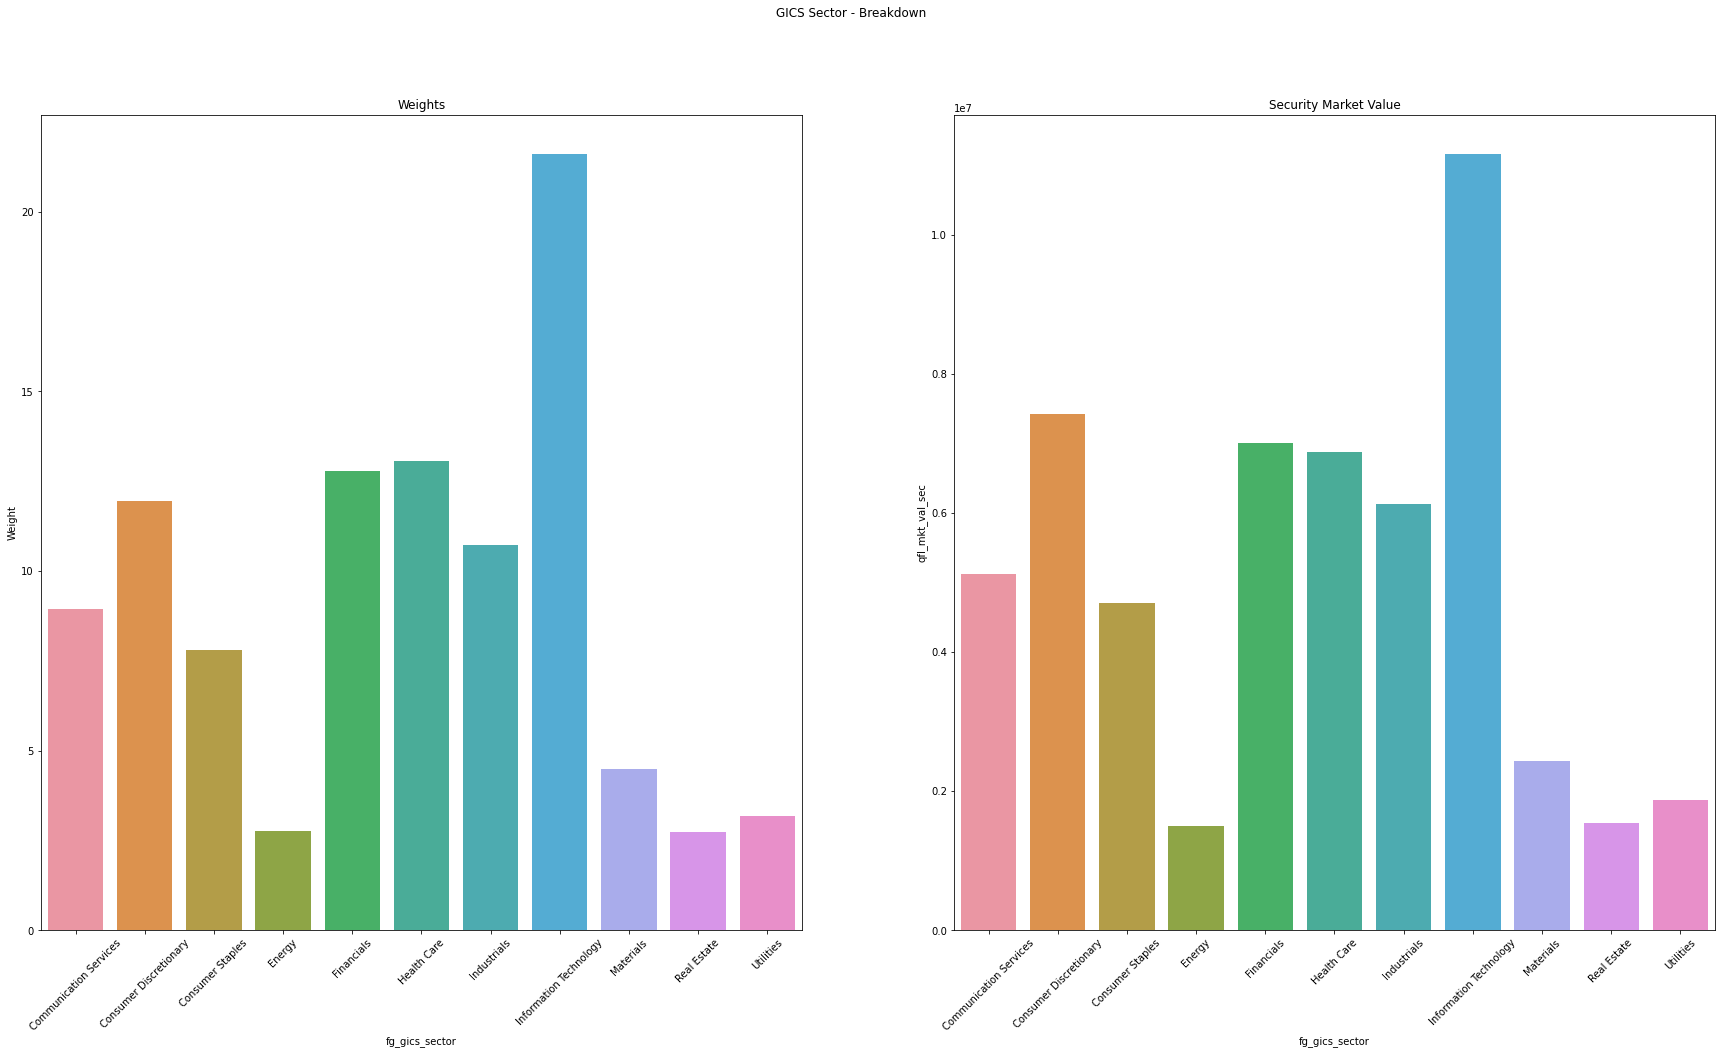

In [34]:
# Group universe

# GICS Sector
GICS_grouped = qfl_df.groupby('fg_gics_sector').sum()

fig, axes = plt.subplots(1, 2, figsize=(30, 15))
fig.suptitle('GICS Sector - Breakdown')
axes[0].set_title('Weights')
axes[1].set_title('Security Market Value')

chart = sns.barplot(ax=axes[0], x = GICS_grouped.index, y = 'Weight', data = GICS_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
chart = sns.barplot(ax=axes[1], x = GICS_grouped.index, y = 'qfl_mkt_val_sec', data = GICS_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);

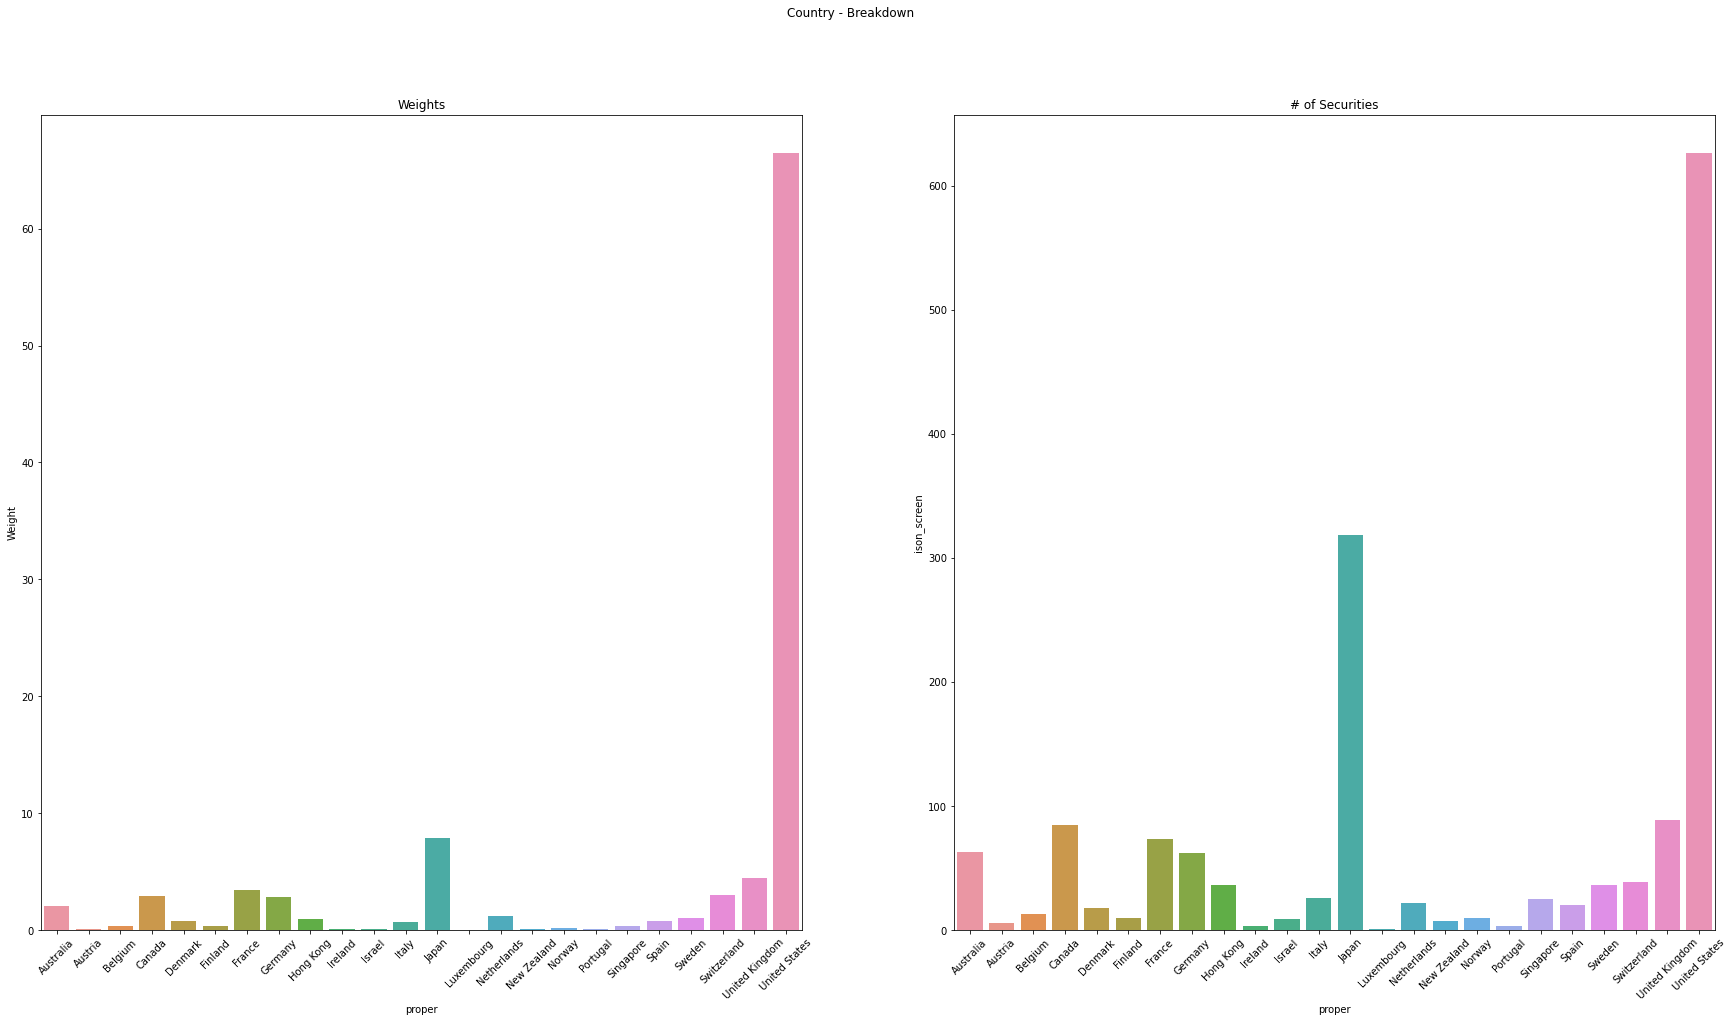

In [35]:
# Group universe

# Country
Country_grouped = qfl_df.groupby('proper').sum()

fig, axes = plt.subplots(1, 2, figsize=(30, 15))
fig.suptitle('Country - Breakdown')
axes[0].set_title('Weights')
axes[1].set_title('# of Securities')

chart = sns.barplot(ax=axes[0], x = Country_grouped.index, y = 'Weight', data = Country_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
chart = sns.barplot(ax=axes[1], x = Country_grouped.index, y = 'ison_screen', data = Country_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);

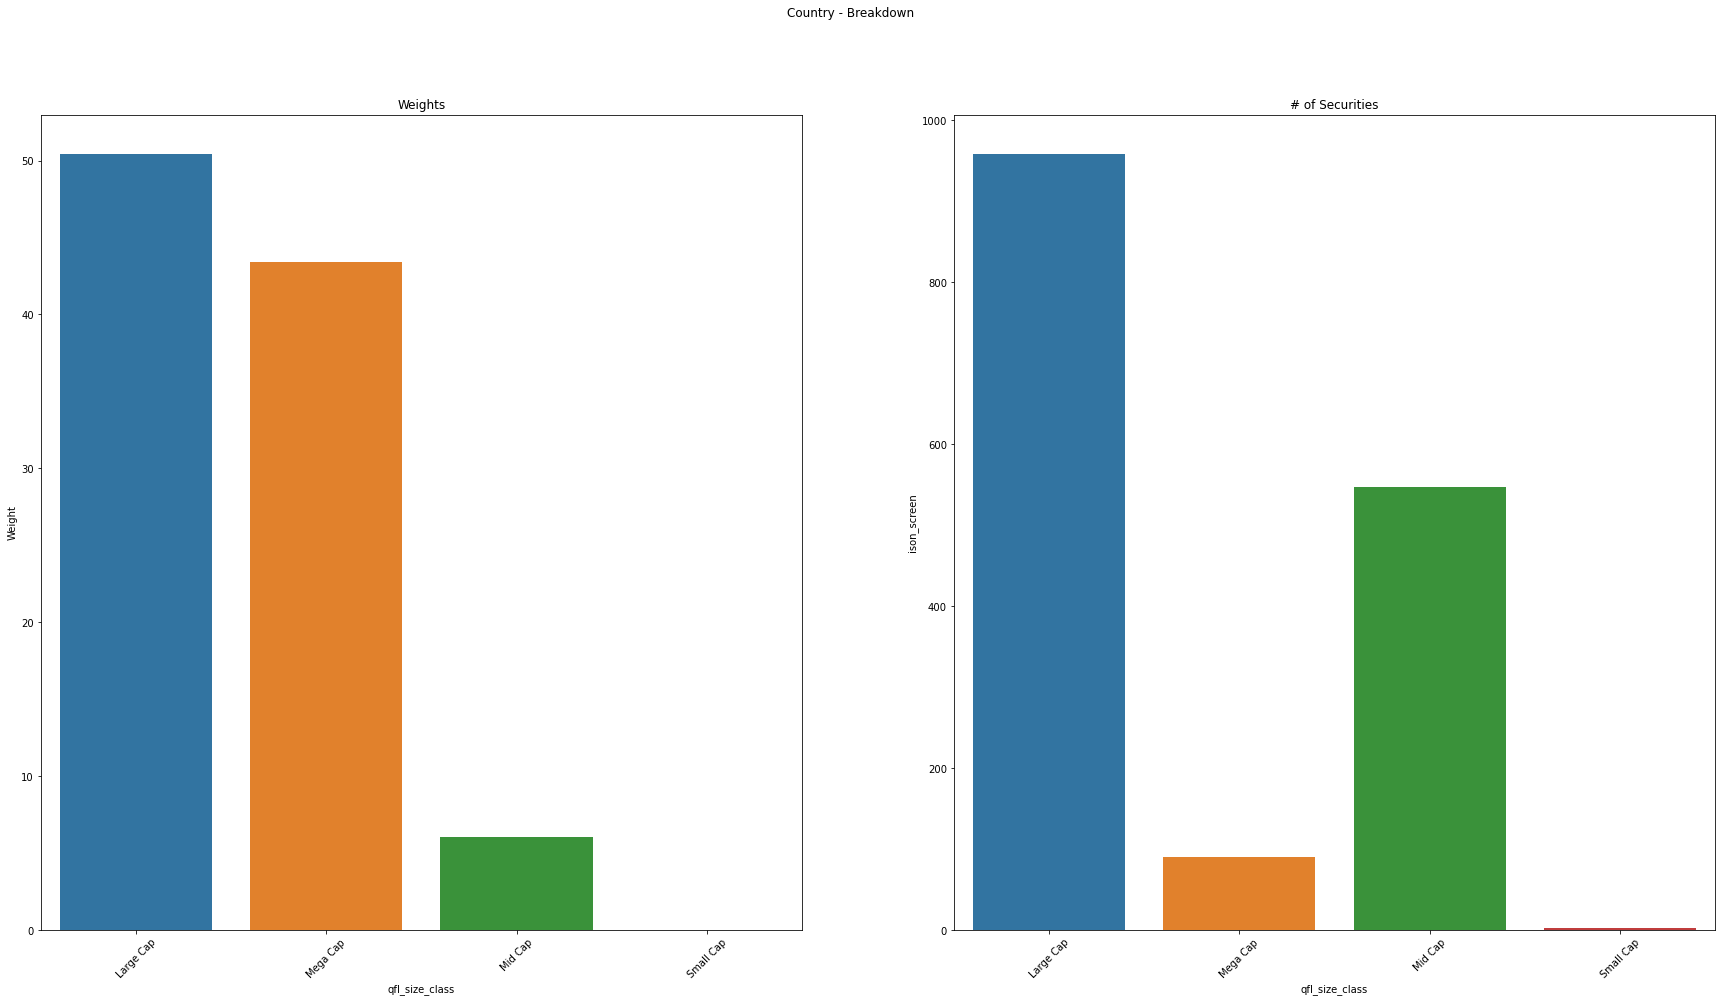

In [36]:
# Group universe

# Size
Size_grouped = qfl_df.groupby('qfl_size_class').sum()

fig, axes = plt.subplots(1, 2, figsize=(30, 15))
fig.suptitle('Country - Breakdown')
axes[0].set_title('Weights')
axes[1].set_title('# of Securities')

chart = sns.barplot(ax=axes[0], x = Size_grouped.index, y = 'Weight', data = Size_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
chart = sns.barplot(ax=axes[1], x = Size_grouped.index, y = 'ison_screen', data = Size_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);

In [37]:
# Feature Selection

In [38]:
# Discard features with more than 80 NAs

qfl_filtered = qfl_df[qfl_df[qfl_df.columns[filter_idx]].isna().sum(axis = 0)[qfl_df[qfl_df.columns[filter_idx]].isna().sum(axis = 0) < 80].index]

In [39]:
# Replace NAs for retained features with feature's average

for col in qfl_filtered.columns:
    qfl_filtered[col] = qfl_filtered[col].replace(np.nan, qfl_filtered[col].mean(axis = 0))
    
qfl_df['p_total_return'] = qfl_df['p_total_return'].replace(np.nan, 0);

<ipython-input-39-d861f91d7765>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qfl_filtered[col] = qfl_filtered[col].replace(np.nan, qfl_filtered[col].mean(axis = 0))


In [40]:
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

X = qfl_filtered
Y = qfl_df['p_total_return']

#RECURSIVE FEATURE ELIMINATION

lin_reg = Lasso()
rfe = RFE(lin_reg, n_features_to_select=3, step = 1)
fit_rfe = rfe.fit(X, Y)
print("Num Features: %s" % (fit_rfe.n_features_))
print("Selected Features: %s" % (fit_rfe.support_))
print("Feature Ranking: %s" % (fit_rfe.ranking_))


Num Features: 3
Selected Features: [False False False False False False False False False False False False
 False False False False  True False False False False False False False
 False False False  True False False False False False False False False
 False  True False False False False]
Feature Ranking: [ 7 24  3 20 18 16 15 14 13  9 27  4 11 33 35 34  1 28 36 38 10  5 12 17
 19 23 25  1 21 30 31 22  8 26 32 29  6  1  2 37 39 40]


In [41]:
qfl_filtered.columns[fit_rfe.support_]

Index(['QFL_ATR(0,36M)', 'QFL_DRAWDOWN(0,252D)', 'QFL_OBV(0,63D)'], dtype='object')

In [42]:
qfl_filtered[qfl_filtered.columns[fit_rfe.support_]].corr()

,"QFL_ATR(0,36M)","QFL_DRAWDOWN(0,252D)","QFL_OBV(0,63D)"
"QFL_ATR(0,36M)",1.000000,0.503751,0.242893
"QFL_DRAWDOWN(0,252D)",0.503751,1.000000,0.134145
"QFL_OBV(0,63D)",0.242893,0.134145,1.000000


In [43]:
qfl_filtered[qfl_filtered.columns[fit_rfe.support_]]

,"QFL_ATR(0,36M)","QFL_DRAWDOWN(0,252D)","QFL_OBV(0,63D)"
0,15.338877,31.427267,-0.483903
1,11.462117,28.039879,-0.075904
2,14.415512,22.744700,-5.485584
3,15.387778,34.592120,-7.116575
4,12.355530,30.790134,3.476768
...,...,...,...
1595,9.561550,53.033535,-3.800763
1596,10.772435,34.171047,-1.837806
1597,10.405935,48.584476,2.383176
1598,15.429597,61.237120,-4.241222


In [44]:
# MFR Z-Score after Feature Selection

qfl_mfr_RFE = pd.DataFrame()

for factor in qfl_filtered[qfl_filtered.columns[fit_rfe.support_]]:
    z_score_RFE = ( qfl_filtered[factor] - qfl_filtered[factor].mean() ) / qfl_filtered[factor].std()
    qfl_mfr_RFE[factor] = z_score_RFE

qfl_mfr_RFE['MFR'] = qfl_mfr_RFE.mean(axis = 1)

qfl_mfr_RFE.head()

,"QFL_ATR(0,36M)","QFL_DRAWDOWN(0,252D)","QFL_OBV(0,63D)",MFR
0,0.403138,-0.788218,-0.283386,-0.222822
1,-0.611260,-1.057265,-0.227297,-0.631941
2,0.161529,-1.477841,-0.970979,-0.762430
3,0.415933,-0.536846,-1.195196,-0.438703
4,-0.377488,-0.838823,0.261097,-0.318405


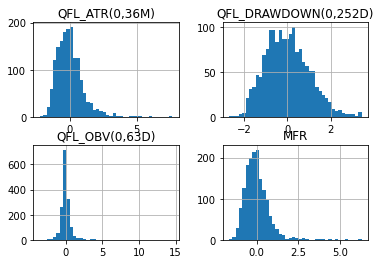

In [45]:
qfl_mfr_RFE.hist(bins = int(np.sqrt(len(qfl_mfr_RFE['MFR']))));

In [46]:
# Check Infomation Coefficient: MFR (Components: RFE's Feature Selected, Z-Scored)

sp_corr_z_rfe, sp_pval_z_rfe = stats.spearmanr(-qfl_mfr_RFE['MFR'].replace(np.nan, 0), qfl_df['p_total_return'].replace(np.nan, 0))
print('Information Coefficient: {0}'.format(round(sp_corr_z_rfe,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z_rfe,2)))

Information Coefficient: -0.23
Information Coefficient (P-Value): 0.0


# Information Coefficient Summary (LVRB)

### Feature Selection: Recoursive Feature Elimination (RFE + Lasso) (3 Top Components)

In [47]:
print('Information Coefficient: {0}'.format(round(sp_corr_z_rfe,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z_rfe,2)))

Information Coefficient: -0.23
Information Coefficient (P-Value): 0.0


### Z-Score + Log-Transformation (All Components)

In [48]:
print('Information Coefficient: {0}'.format(round(sp_corr_z_log,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z_log,2)))

Information Coefficient: -0.19
Information Coefficient (P-Value): 0.0


### Z-Score Only (All Components)

In [49]:
print('Information Coefficient: {0}'.format(round(sp_corr_z,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z,2)))

Information Coefficient: 0.05
Information Coefficient (P-Value): 0.04
